In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
from IPython.display import display, clear_output

In [3]:
import sys
sys.path.append('../../..')

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  warn(f"Failed to load image Python extension: {e}")


In [5]:
from magrec.misc.load import load_matlab_data

In [6]:
# mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ.mat")
mat = load_matlab_data(__datapath__ / "experimental" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ.mat")

B_NV = torch.tensor(mat['Bnv_map'].T)  
B_NV.shape  # (39, 141) — notice that it is probably bad to have an odd number of pixels

torch.Size([141, 39])

## 1. Reconstruction of B fields

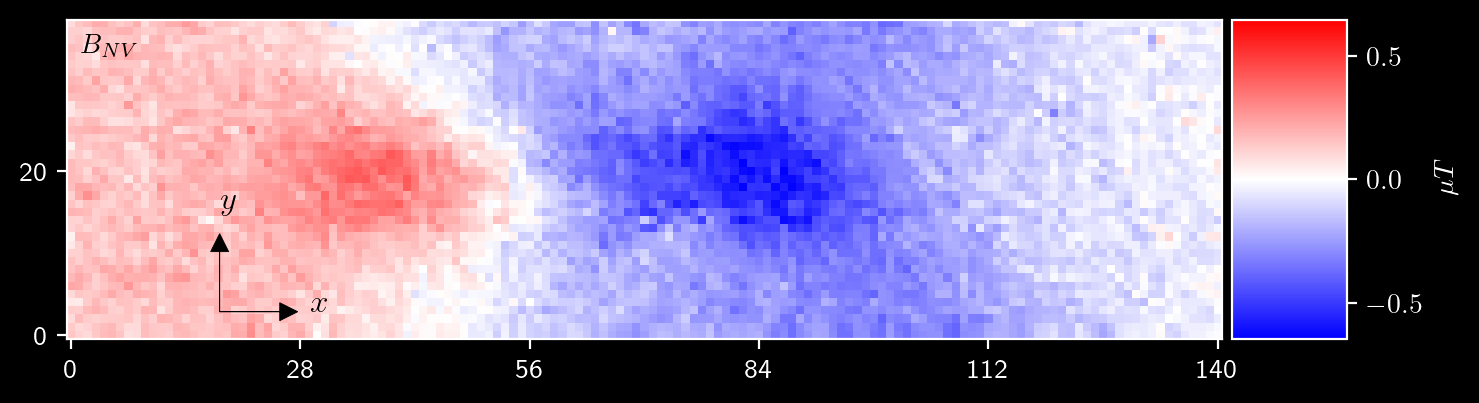

In [7]:
plot_n_components(B_NV * 1e6, labels=[r'$B_{NV}$'], cmap="bwr", units=r"$\mu T$")

In [8]:
# inspect the coordinate vectors to check for spacing
x_vector = mat["rx_inv"]
y_vector = mat["ry_inv"]

print(np.unique(np.diff(x_vector)))
print(np.unique(np.diff(y_vector)))

[0.01692525 0.01692525 0.01692525 0.01692525 0.01692525 0.01692525
 0.01692525 0.01692525 0.01692525]
[0.02916667 0.02916667 0.02916667 0.02916667 0.02916667 0.02916667
 0.02916667]


In [9]:
# data from inspecting the matlab file  
dx=0.0169  # in μm
dy=0.0292

# data from the .pptx shared by the authors
theta = 54.7  # degrees
phi = 30.0 +90 # degrees

ft = FourierTransform2d(B_NV.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b_NV = ft.forward(B_NV, dim=(-2, -1))

kernel.shape


torch.Size([3, 141, 20])

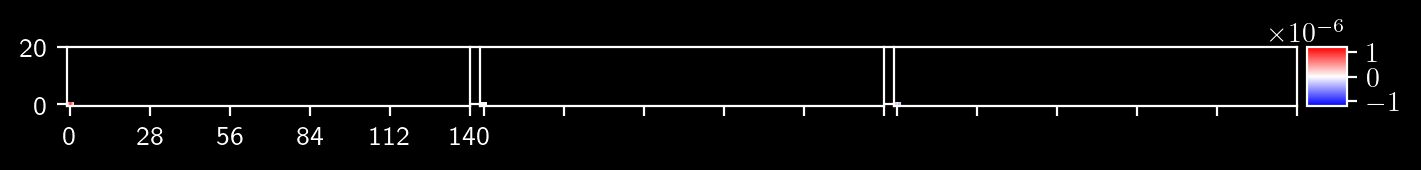

In [10]:

b = torch.einsum("jkl,kl->jkl", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B[0,::] = B[0,::] + 5e-7 

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic", "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()]})

# plot_n_components(B[:,:,40:80], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
# imshow_kwargs={"interpolation": "bicubic", "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()]})


In [11]:
# padded_B_NV = FourierPadder.pad_2d(B_NV)
# padded_B_NV = FourierPadder.pad_2d(B_NV, (10,10), 'linear_ramp', plot=True)

ft = FourierTransform2d(padded_B_NV.shape, dx=dx, dy=dy)
b_NV = ft.forward(padded_B_NV, dim=(-2, -1))
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b = torch.einsum("cjk,jk->cjk", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B.shape # (3, n_x, n_y) <- this should give real vector field map

NameError: name 'padded_B_NV' is not defined

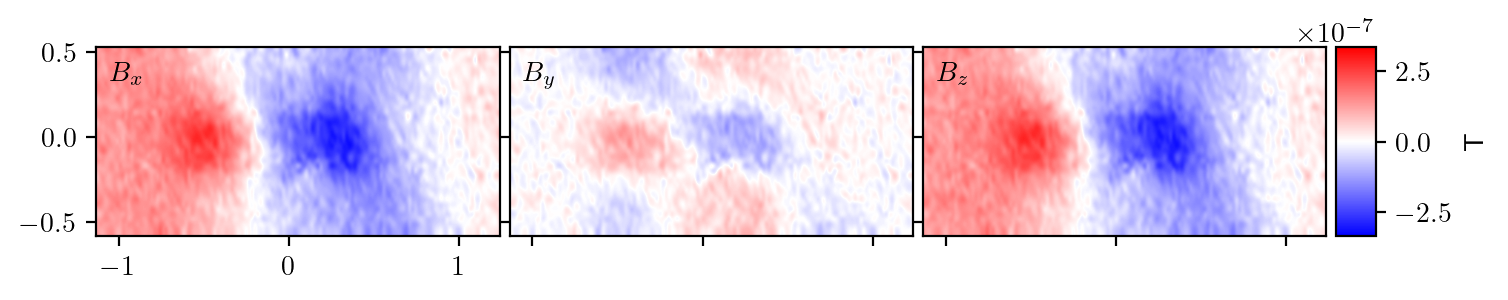

In [ ]:
plot_n_components(B[:, :141, :39], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", units="T",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

In [ ]:
height = 0.015 # in μm
layer_thickness = 0 # put 1 for now to get result per μm
inversion_kernel = MagneticFieldToCurrentInversion2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

Applied a high frequency filter, removing all components smaller than 0.015 um
Applied a high frequency filter, removing all components smaller than 0.015 um


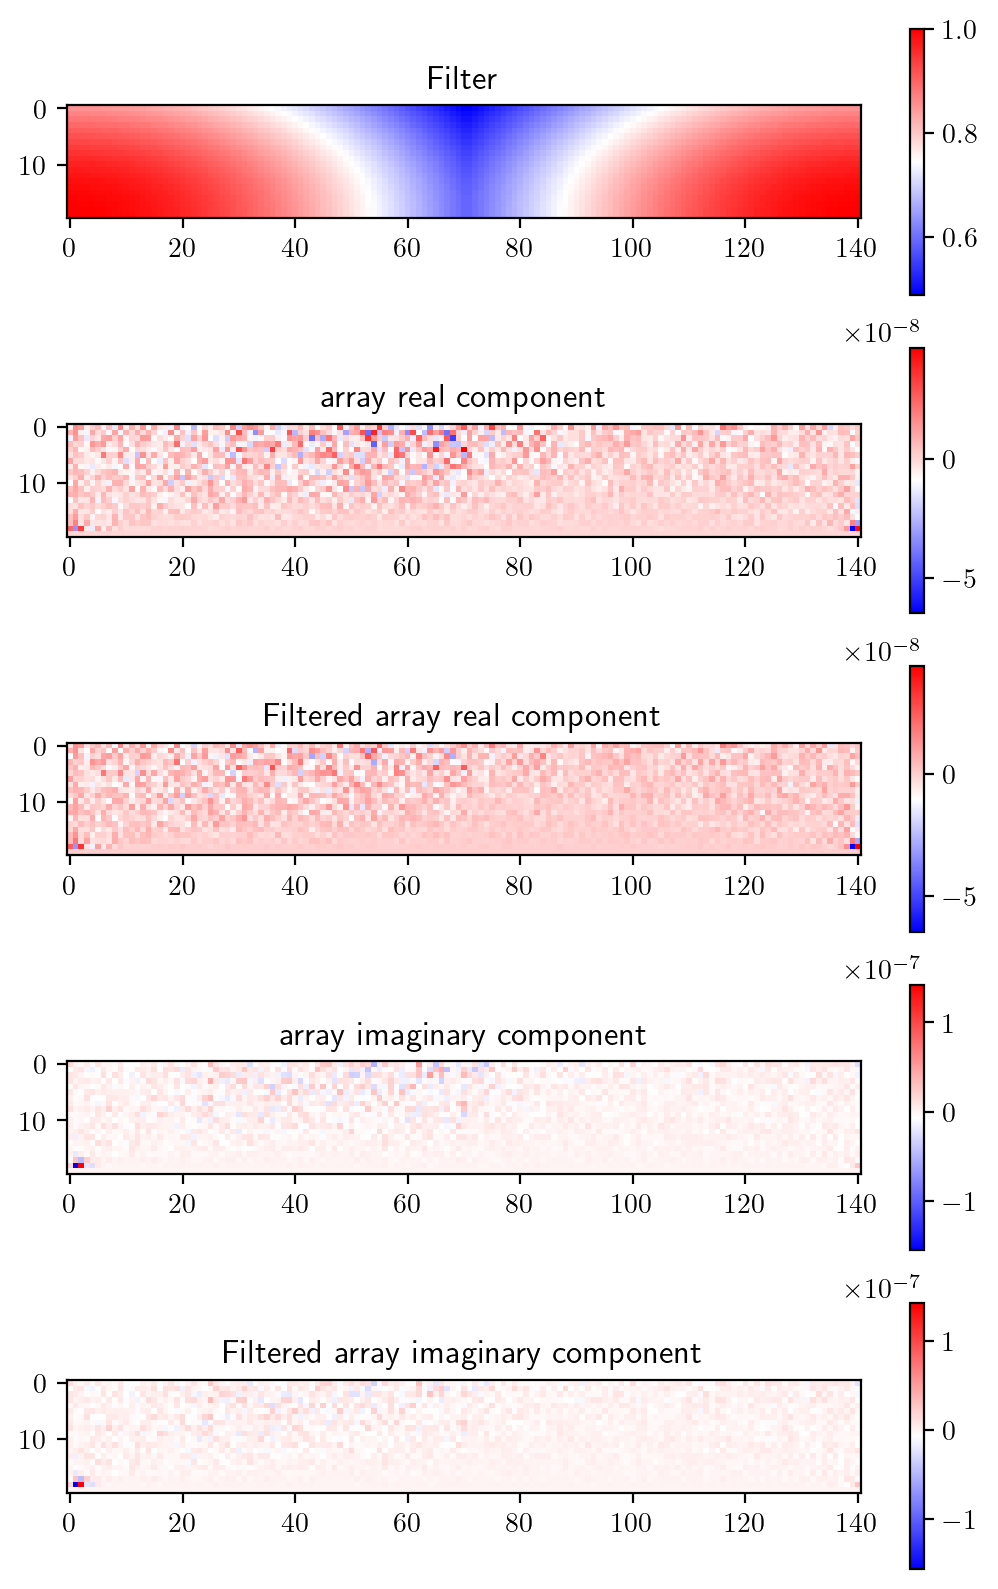

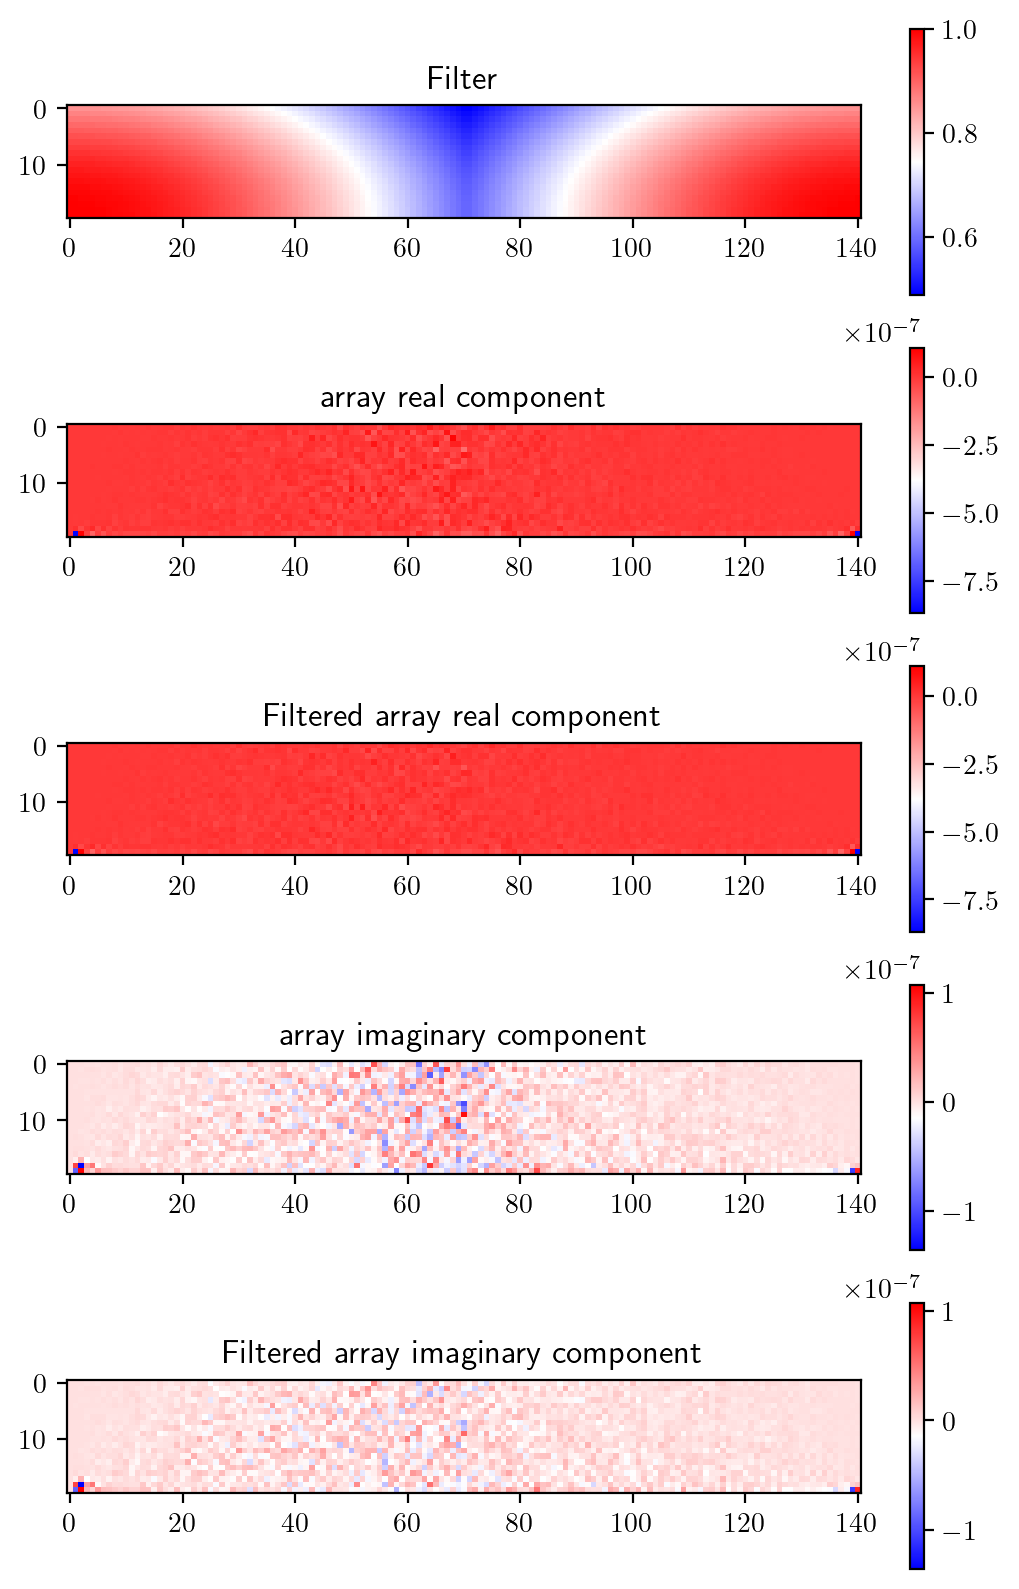

In [ ]:
bxby = b[:2, :, :].type(dtype=torch.complex64)
jxjy = torch.einsum('vcjk,cjk->vjk', inversion_kernel, bxby)
jxjy[0,::] = FourierPadder.apply_hanning(jxjy[0,::], ft.k_matrix, height, high_freq_cutoff = height, low_freq_cutoff = None, plot = True)
jxjy[1,::] = FourierPadder.apply_hanning(jxjy[1,::], ft.k_matrix, height, high_freq_cutoff = height, low_freq_cutoff = None, plot = True)
JxJy = ft.backward(jxjy, dim=(-2, -1))

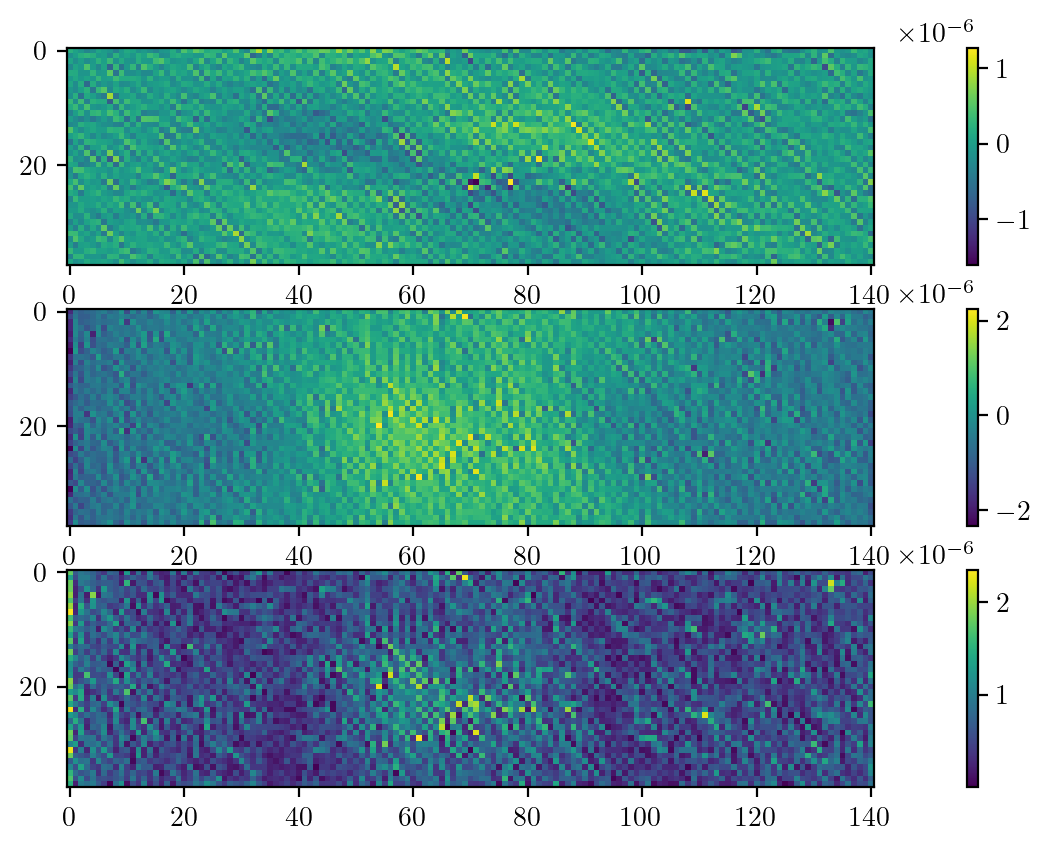

In [ ]:
fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(3,1,1)
plt.imshow(np.rot90(JxJy[0,::]))
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(np.rot90(JxJy[1,::]))
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(np.rot90(np.sqrt(JxJy[0,::]**2 + JxJy[1,::]**2)))
plt.colorbar()

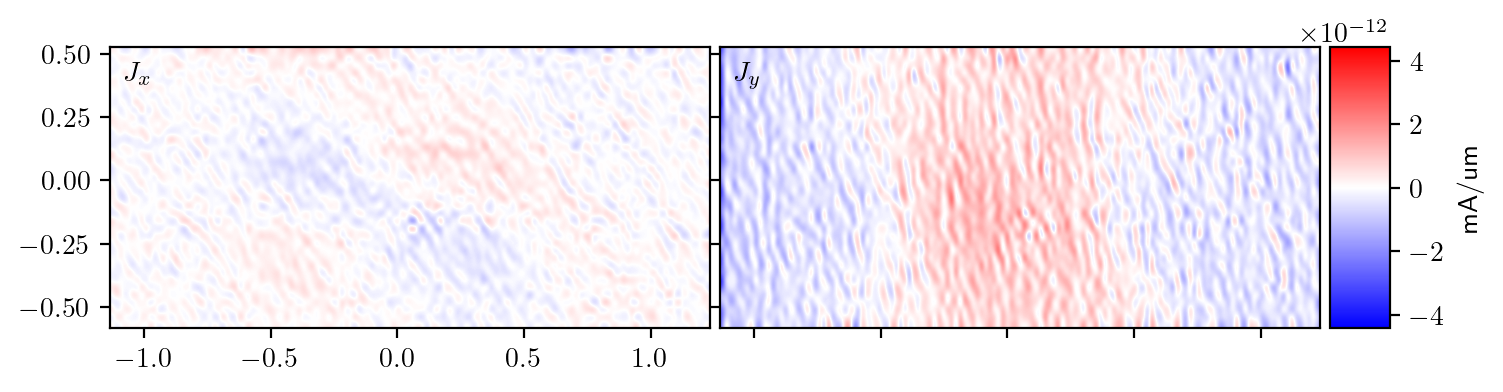

In [ ]:
plot_n_components(JxJy * 1e-6, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

## 2. Reconstruction of J by optimization

Here we define a reconstruction scheme by doing an optimization on a tensor of J with two components, so that it produces the expected magnetic field through propagation. 

### 2.3. Define data

dict_keys(['__header__', '__version__', '__globals__', 'BX_map', 'BY_map', 'BZ_map', 'Bnv_map', 'Jx_o_cut', 'Jy_o_cut', 'rx_inv', 'ry_inv'])


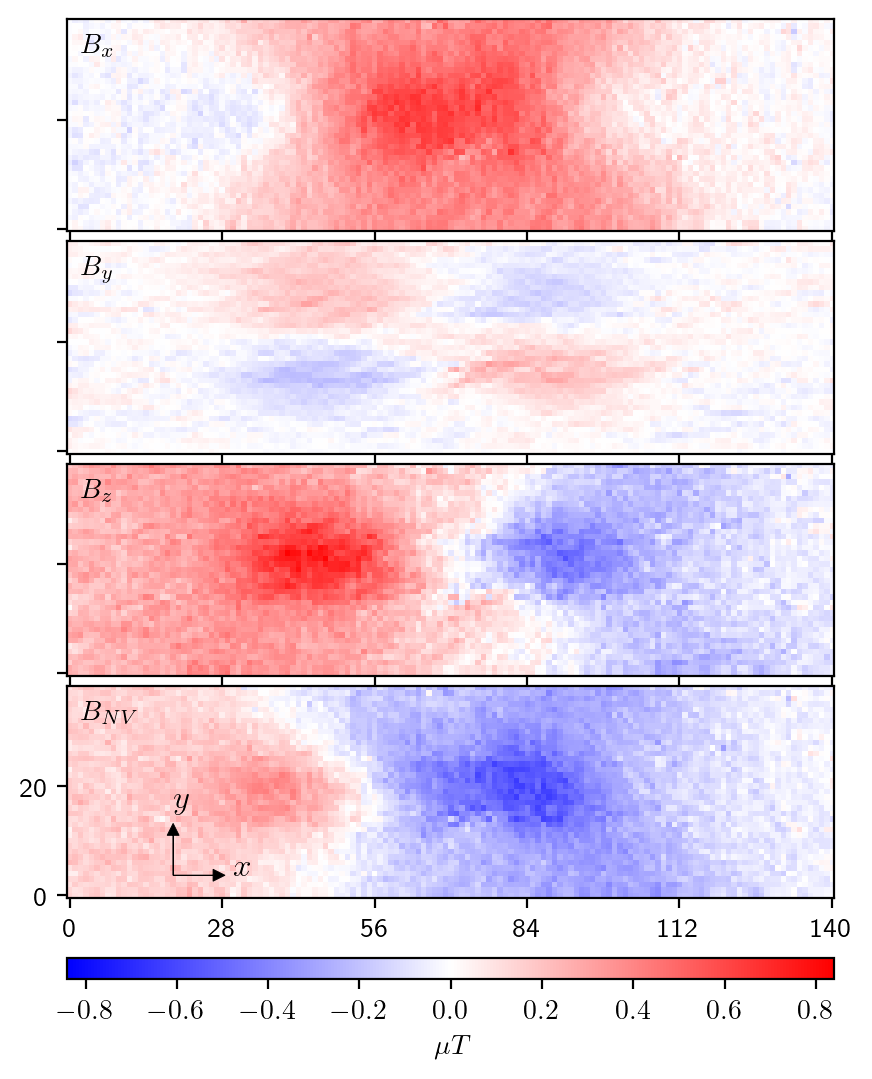

In [ ]:
print(mat.keys())

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0) * 1e6 # convert to μT

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units=r"$\mu T$", alignment="vertical",)

### 2.2. Define parameters

In [14]:
dx = 0.0169  # μm
dy = 0.0292

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30.0              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

### 2.3. Define J → B transformation and optimizer loop

In [ ]:
W, H = B.shape[-2:]
pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

# calculate what the next power of two is
expanded_shape = (2, 1024, 512)

# calculate the required padding to get to the expanded shape
pad_width = (expanded_shape[1] - W*3) 
pad_height = (expanded_shape[2] - H*3)

# if the padding is odd, we need to add one more pixel to the right and bottom
if pad_width % 2 == 1:
    pad_left = pad_width // 2 + 1
    pad_right = pad_width // 2
else:
    pad_left = pad_width // 2
    pad_right = pad_width // 2

# similar to height
if pad_height % 2 == 1:
    pad_bottom = pad_height // 2 + 1
    pad_top = pad_height // 2
else:
    pad_bottom = pad_height // 2
    pad_top = pad_height // 2

# calculate the ROI to crop the result to
roi_width = pad_left + W
roi_height = pad_bottom + H

pad_zero = torch.nn.ZeroPad2d((pad_bottom, pad_top, pad_left, pad_right))
propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

def compute_B_with_repl(J: torch.tensor):
    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., roi_width:roi_width+W, roi_height:roi_height+H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., :, :]], 
                     dim=-3)
    return B

### 2.4. Define optimization loop

In [ ]:

def run_optimization_repl(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, W, H), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_with_repl(J)
        
        # Compute the loss
        loss = loss_fn(B_pred, B)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            # if loss.item() < 1e-10:
            #     print('Stopping optimization, converged to a loss of < 1e-10')
            #     break

    return J

Loss at iteration 900: 0.02159346640110016


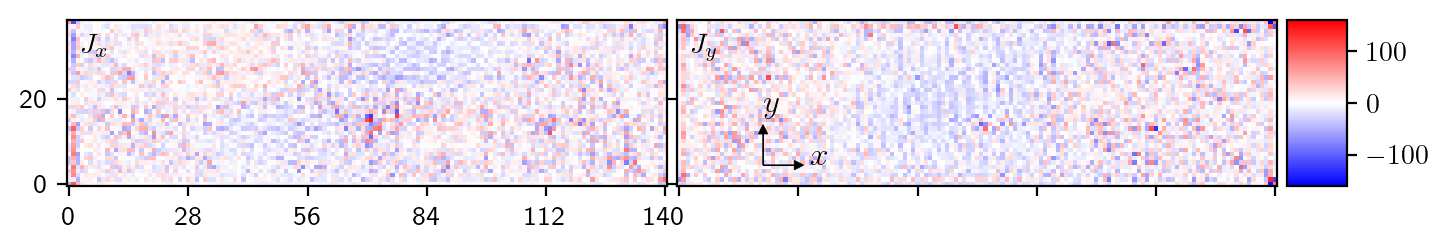

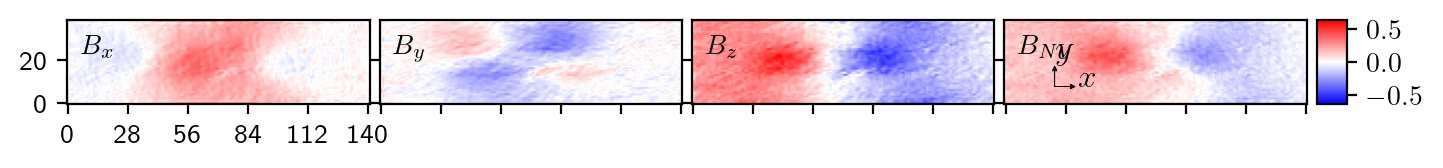

In [ ]:
J_pred = run_optimization_repl(B, n_iter=1000, plot_interval=100)

# Second Dataset 

In [10]:
# mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")
mat = load_matlab_data(__datapath__ / "experimental" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0) * 1e6  # Convert to μT
B = torch.tensor(B, dtype=torch.float32)

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units="T", alignment="vertical",)

dx = 0.0169  # μm
dy = 0.0292

height = 0.015          # μm
layer_thickness = 0.030 # μm

# theta = 54.7            # degrees
theta = 35.0  # predicted by David|
phi = 30.0              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

In [7]:
dx = 0.0204  # μm
dy = 0.0291

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = -54.7            # degrees
phi = -150              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

W, H = B.shape[-2:]
pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

# calculate what the next power of two is
expanded_shape = (2, 1024, 512)

# calculate the required padding to get to the expanded shape
pad_width = (expanded_shape[1] - W*3) 
pad_height = (expanded_shape[2] - H*3)

# if the padding is odd, we need to add one more pixel to the right and bottom
if pad_width % 2 == 1:
    pad_left = pad_width // 2 + 1
    pad_right = pad_width // 2
else:
    pad_left = pad_width // 2
    pad_right = pad_width // 2

# similar to height
if pad_height % 2 == 1:
    pad_bottom = pad_height // 2 + 1
    pad_top = pad_height // 2
else:
    pad_bottom = pad_height // 2
    pad_top = pad_height // 2

# calculate the ROI to crop the result to
roi_width = pad_left + W
roi_height = pad_bottom + H

pad_zero = torch.nn.ZeroPad2d((pad_bottom, pad_top, pad_left, pad_right))
propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

def compute_B_with_repl(J: torch.tensor):
    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., roi_width:roi_width+W, roi_height:roi_height+H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., :, :]], 
                     dim=-3)
    return B

def run_optimization_repl(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, W, H), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_with_repl(J)
        
        # Compute the loss
        loss = loss_fn(B_pred, B)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            # if loss.item() < 1e-10:
            #     print('Stopping optimization, converged to a loss of < 1e-10')
            #     break

    return J

In [16]:
J_pred = run_optimization_repl(B, n_iter=1000, plot_interval=100)

TypeError: expected np.ndarray (got Tensor)

## 3. Reconstruction of J with a conv net

In [ ]:
from magrec.nn.utils import create_zero_padder

# Here we define the loss function and the optimization algorithm
def train_net(B, net: torch.nn.Module = None, n_iter=1000, plot_interval=100, lr=1.):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam
    if net is None:
        net = GeneratorCNN(n_channels_in=4, n_channels_out=2)

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters(), lr=lr)

    # Convert B to a torch tensor of float32
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).float()
    else:
        B = B.float()

    # Pad B with replication to the closest multiple of 16
    minimal_size = np.ceil(np.array(B.shape[-2:]) / 16) * 16
    pad_size = minimal_size - np.array(B.shape[-2:])
    B = torch.nn.functional.pad(B, pad=(0, int(pad_size[1]), 0, int(pad_size[0])), mode='replicate')

    # Extract the B_NV component from the measured B
    B_NV = B[3, ...]

    # Add a batch dimension, since we are optimizing only on one sample
    B = B[None, ...]
    B_NV = B_NV[None, None, ...]

    W, H = B.shape[-2:]

    
    pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

    # calculate what the next power of two is
    expanded_shape = (2, 512, 512)
    

    pad_zero, (roi_left, roi_bottom) = create_zero_padder(expanded_shape[-2:], W, H)

    propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                    dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

    def compute_B_with_repl(J: torch.tensor):
        J = pad_repl(J)
        J = pad_zero(J)
        B = propagator(J)
        B_NV = proj.project(B)
        # That's a more general stacking to allow for batch dimension
        B = torch.stack([B[..., -3, :, :], 
                        B[..., -2, :, :], 
                        B[..., -1, :, :], 
                    B_NV[..., :, :]], 
                        dim=-3)
        return B[..., roi_left:roi_left+W, roi_bottom:roi_bottom+H]


    # Initialize a list to track loss and update it on each iteration
    track_loss = []

    # Prepare a figure to plot the loss
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_rec):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_rec.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)
        
        # Make y axis log scale
        ax_loss.set_yscale('log')

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)


    def print_changed_lr(lr):
        """Print once if the learning rate changed"""
        if print_changed_lr.current_lr != lr:
            print(f"Learning rate changed to {lr}")
        print_changed_lr.current_lr = lr

    print_changed_lr.current_lr = 1

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        J_pred = net(B)

        # Compute the predicted B that corresponds to the output current
        B_pred = compute_B_with_repl(J_pred)

        # Extract the B_NV component
        B_pred_NV = B_pred[:, 3, ...]

        # Add a dimension that corresponds to the component
        B_pred_NV = B_pred_NV[:, None, ...]
        
        # Compute the loss
        loss = loss_fn(B, B_pred)
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            show_progress(B_pred, J_pred)

    return net

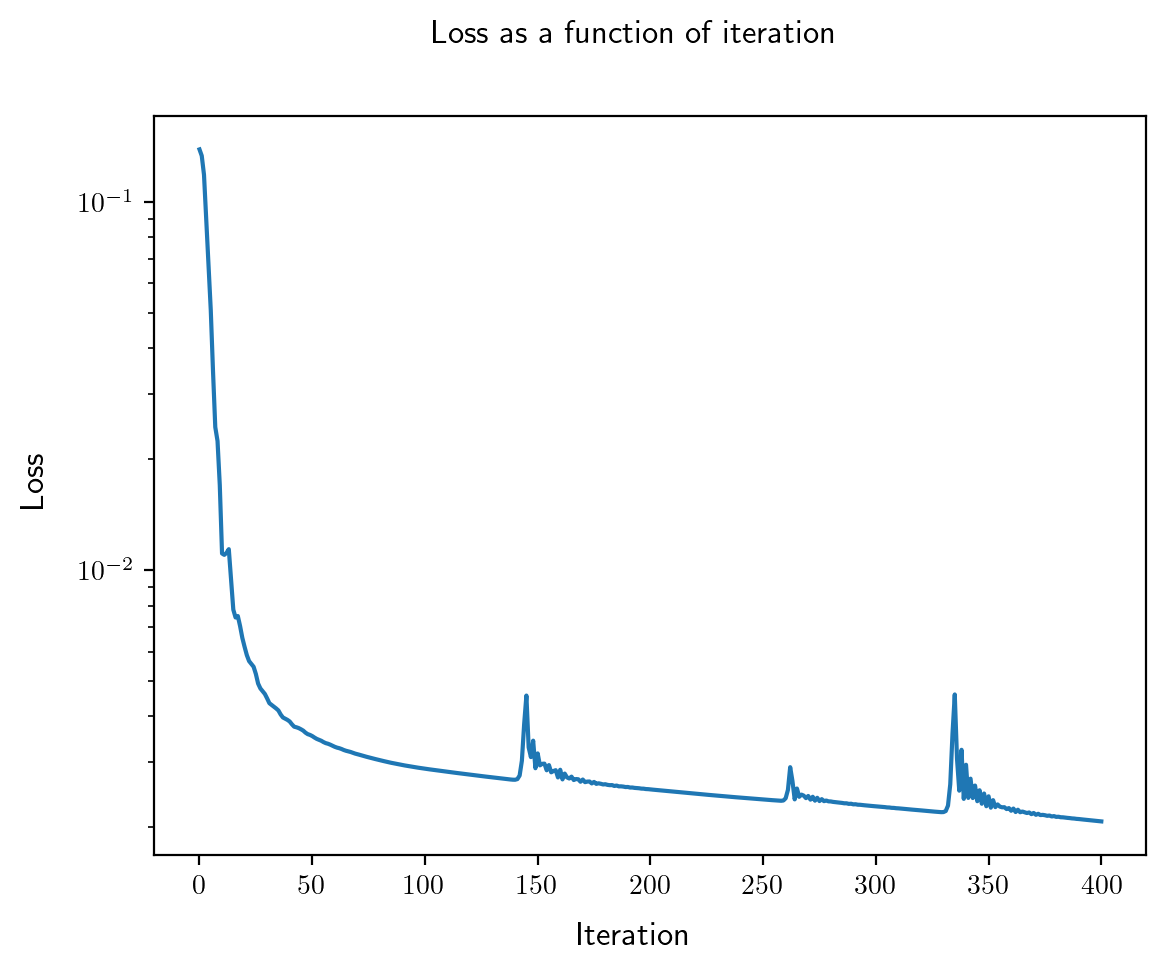

In [ ]:
net = train_net(B, n_iter=500, plot_interval=100, lr=0.01)

In [ ]:
def test_net(net: torch.nn.Module, B: torch.Tensor):
    net.eval()

    # Convert B to a torch tensor of float32
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).float()
    else: 
        B = B.float()

    B = B[None, ...]
    B_NV = B[:, 3, ...]

    J_pred = net(B)
    B_pred = compute_B_with_repl(J_pred)

    fig1 = plot_n_components(J_pred.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
    fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

    display(fig1, fig2)
    pass

### 3.2. Conv net that reconstucts only from one component

In [ ]:
# Here we define the loss function and the optimization algorithm
def train_net(B, net: torch.nn.Module = None, n_iter=1000, plot_interval=100, lr=1.):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam
    if net is None:
        net = GeneratorCNN(n_channels_in=1, n_channels_out=2)

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters(), lr=lr)

    # Convert B to a torch tensor of float32
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).float()
    else:
        B = B.float()

    # Pad B with replication to the closest multiple of 16
    minimal_size = np.ceil(np.array(B.shape[-2:]) / 16) * 16
    pad_size = minimal_size - np.array(B.shape[-2:])
    B = torch.nn.functional.pad(B, pad=(0, int(pad_size[1]), 0, int(pad_size[0])), mode='replicate')

    # Show how the training data looks like
    plot_n_components(B.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

    # Extract the B_NV component from the measured B
    B_NV = B[3, ...]

    # Add a batch dimension, since we are optimizing only on one sample
    B = B[None, ...]
    B_NV = B_NV[None, None, ...]

    W, H = B.shape[-2:]

    
    pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

    # calculate what the next power of two is
    expanded_shape = (2, 512, 512)

    # 384, 192
    

    pad_zero, (roi_left, roi_bottom) = create_zero_padder(expanded_shape[-2:], W, H)

    propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                    dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

    def compute_B_with_repl(J: torch.tensor):
        J = pad_repl(J)
        J = pad_zero(J)
        B = propagator(J)
        B_NV = proj.project(B)
        # That's a more general stacking to allow for batch dimension
        B = torch.stack([
            B[..., -3, :, :], 
            B[..., -2, :, :], 
            B[..., -1, :, :], 
            B_NV[..., :, :]
            ], dim=-3,)
        B_roi = B[..., roi_left:roi_left+W, roi_bottom:roi_bottom+H]
        return B_roi 


    # Initialize a list to track loss and update it on each iteration
    track_loss = []

    # Prepare a figure to plot the loss
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_rec):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_rec.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)
        
        # Make y axis log scale
        ax_loss.set_yscale('log')

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)


    def print_changed_lr(lr):
        """Print once if the learning rate changed"""
        if print_changed_lr.current_lr != lr:
            print(f"Learning rate changed to {lr}")
        print_changed_lr.current_lr = lr

    print_changed_lr.current_lr = 1

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        J_pred = net(B_NV)

        # Compute the predicted B that corresponds to the output current
        B_pred = compute_B_with_repl(J_pred)

        # Extract the B_NV component
        B_pred_NV = B_pred[:, 3, ...]

        # Add a dimension that corresponds to the component
        B_pred_NV = B_pred_NV[:, None, ...]
        
        # Compute the loss
        loss = loss_fn(B_NV, B_pred_NV)
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            show_progress(B_pred, J_pred)

        
        # If the loss is small enough, stop the optimization
        if loss.item() < 1e-6:
            print('Stopping optimization, converged to a loss of < 1e-10')
            show_progress(B_pred, J_pred)
            break

    return net

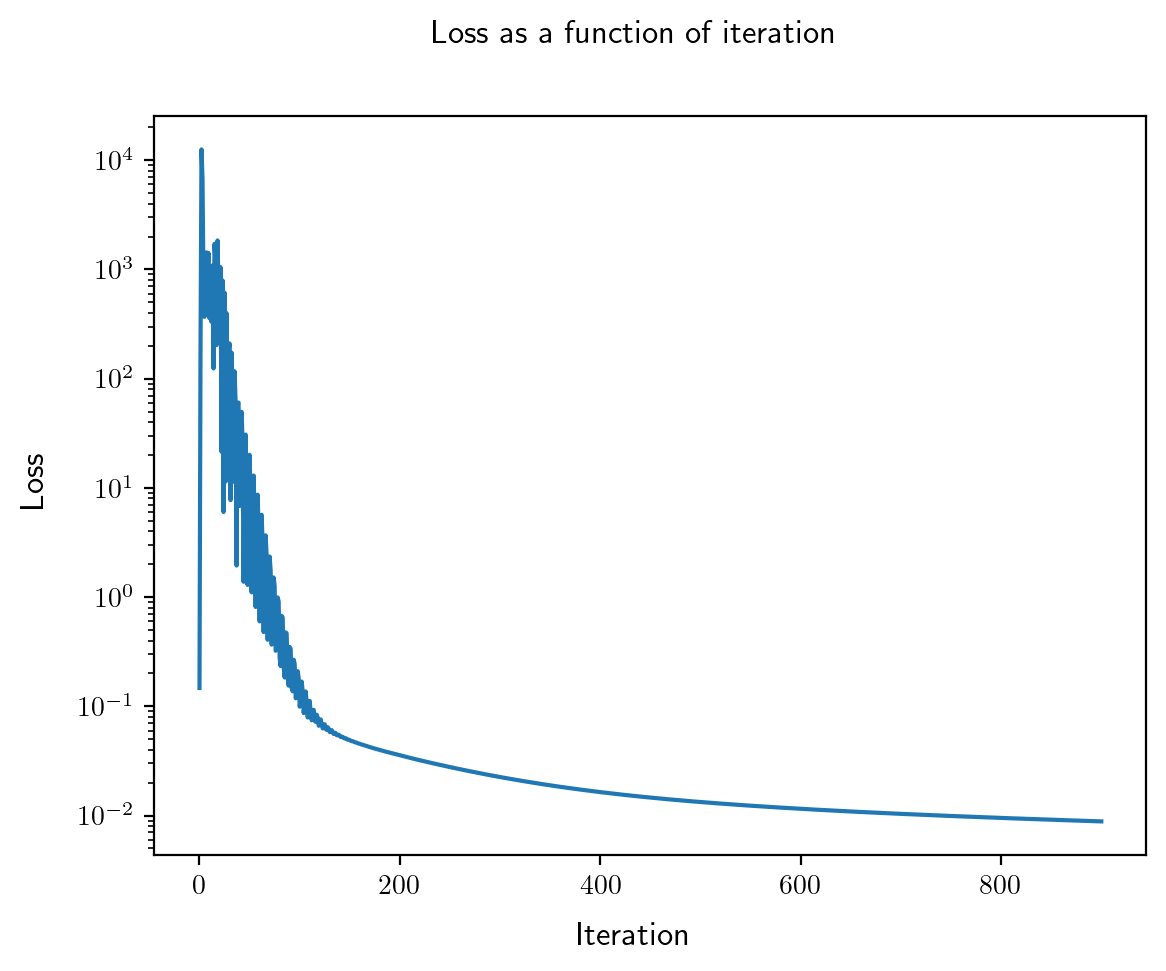

In [ ]:
net_1 = train_net(B, n_iter=1000, plot_interval=100)

## Push to AI

In [11]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
    FourierDivergence2d,
)

import skorch

from magrec.scripts.prototype_pipeline import Prototype
import torchvision.transforms as T

from magrec.nn.arch import UNet, BnCNN, FCCNN, GioUNet, GioCNN

from magrec.scripts.prototype_pipeline import Prototype, AdjustLROnLoss, LRScheduler

In [12]:
from magrec.nn.arch import GioUNet

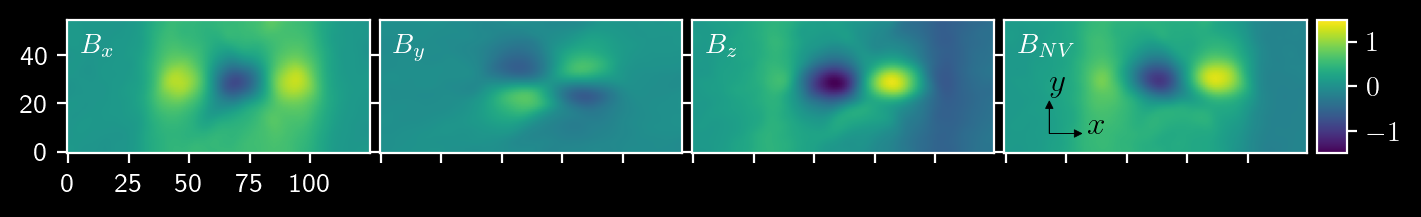

In [13]:
_, W, H = B.shape

padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('add_batch_dim', Function(lambda x: x[None, ...])),
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"])),
    ('B_NV', Function(lambda x: x[..., 0:1, :, :])),
])

pipe.fit(B).transform(B);

model = Pipe([
    ('JxJy', Union([('Jx', 'passthrough'), ('Jy', FourierZeroDivergenceConstraint2d())], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
    ('ROI', Function(T.CenterCrop(size=(W, H)))),
])

recon = Prototype(
    net=GioCNN(size_out=(128, 128), n_channels_in=1, n_channels_out=1),
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    optimizer=torch.optim.SGD,
    callbacks=[LRScheduler(policy=AdjustLROnLoss, 
                        loss_vals=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 
                        lr_vals=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
                        )]
    )


  epoch    train_loss        lr       dur
-------  ------------  --------  --------
   1723      3.51e-03  1.00e-01  3.38e-02
   1800      3.06e-03  1.00e-02  2.62e-02
   1900      2.68e-03  1.00e-02  3.34e-02
   2000      2.41e-03  1.00e-02  3.02e-02
   2100      2.20e-03  1.00e-02  2.55e-02
   2200      2.04e-03  1.00e-02  3.06e-02
   2300      1.90e-03  1.00e-02  2.87e-02
   2400      1.79e-03  1.00e-02  5.44e-02
   2500      1.69e-03  1.00e-02  3.95e-02
   2600      1.60e-03  1.00e-02  2.85e-02
   2700      1.51e-03  1.00e-02  2.83e-02
   2800      1.44e-03  1.00e-02  2.48e-02
   2900      1.38e-03  1.00e-02  2.63e-02
   3000      1.32e-03  1.00e-02  2.56e-02
   3100      1.26e-03  1.00e-02  2.98e-02
   3200      1.21e-03  1.00e-02  2.52e-02
   3300      1.16e-03  1.00e-02  4.68e-02
   3400      1.12e-03  1.00e-02  2.95e-02
   3500      1.08e-03  1.00e-02  2.38e-02
   3600      1.04e-03  1.00e-02  2.51e-02
   3700      1.01e-03  1.00e-02  4.10e-02
   3800      9.97e-04  1.00e-03  4

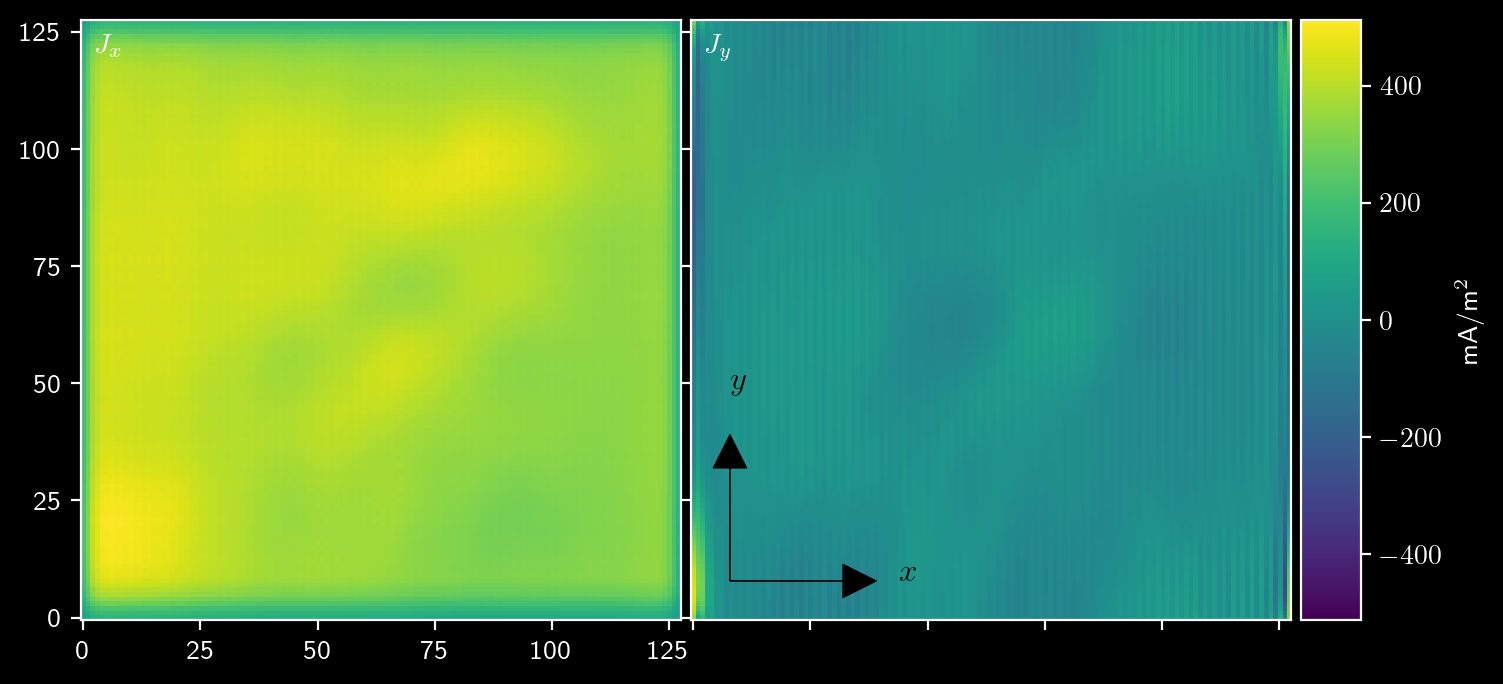

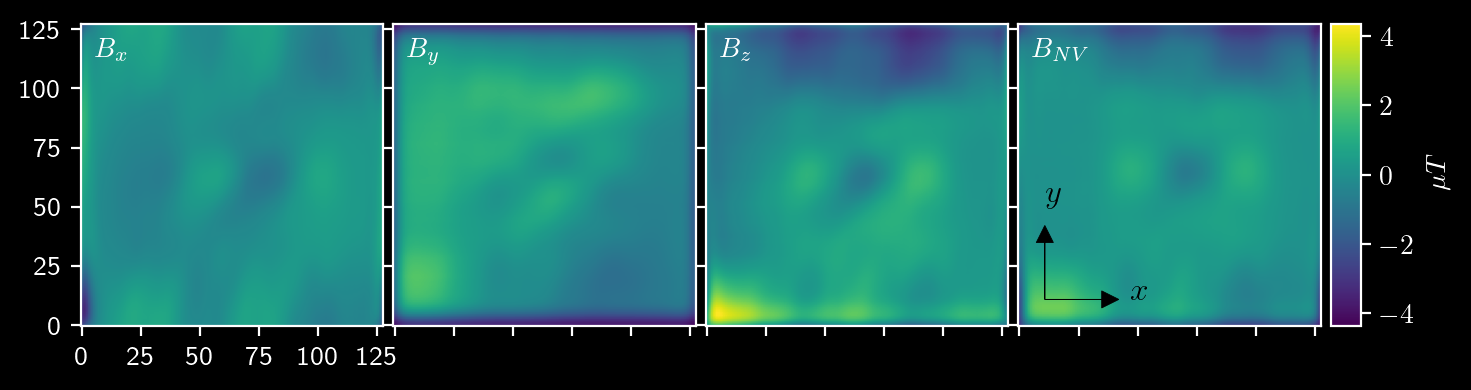

tensor([[[[-0.1571, -0.1602, -0.1628,  ...,  0.2738,  0.2775,  0.2815],
          [ 0.1005,  0.0818,  0.0662,  ...,  0.1398,  0.1397,  0.1411],
          [ 0.2257,  0.1963,  0.1719,  ...,  0.0776,  0.0762,  0.0773],
          ...,
          [ 0.1927,  0.1843,  0.1747,  ...,  0.0232,  0.0049, -0.0179],
          [ 0.1484,  0.1451,  0.1403,  ..., -0.0009, -0.0252, -0.0545],
          [-0.0655, -0.0582, -0.0532,  ...,  0.1073,  0.0845,  0.0571]]]],
       grad_fn=<SliceBackward0>)

In [15]:
recon.propagate(B, epochs=5000, print_log_every=100, callbacks__print_log__floatfmt=".2e", lr=0.1, optimizer__momentum=0.5)

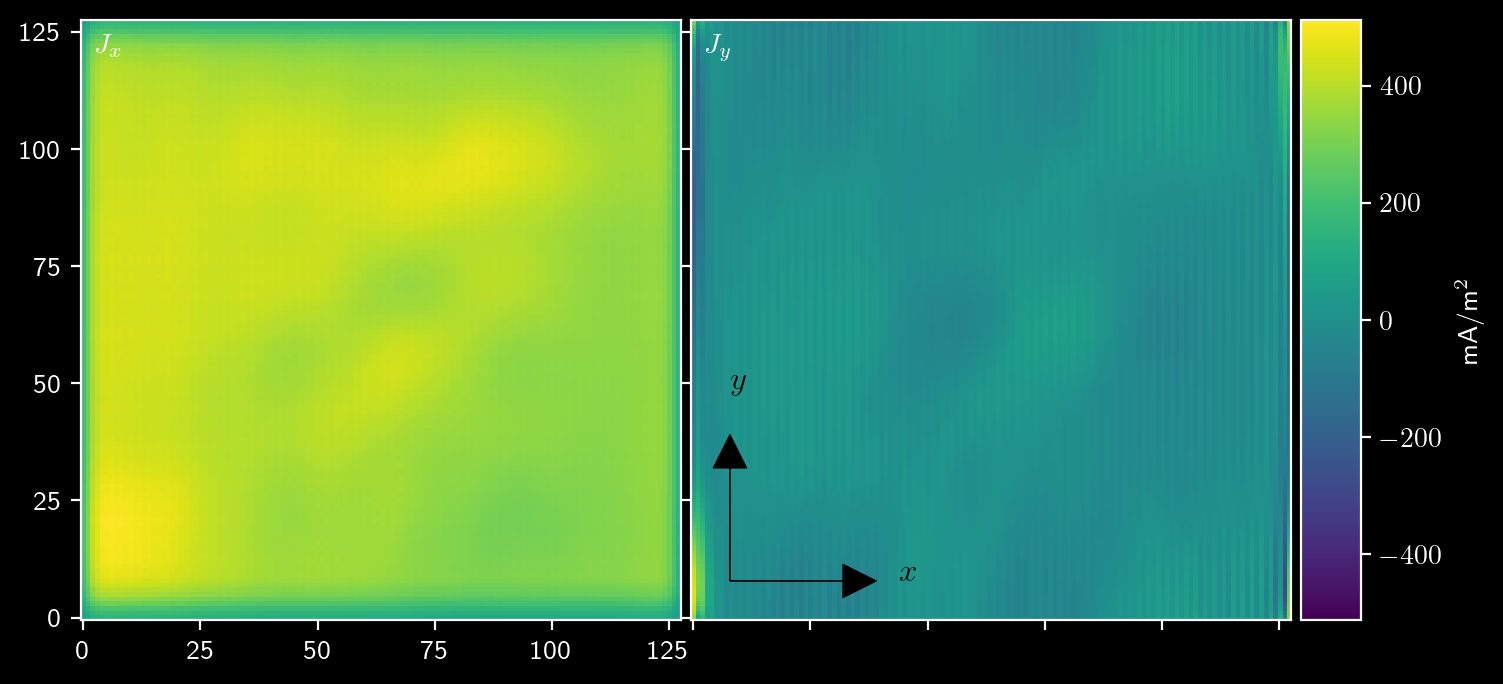

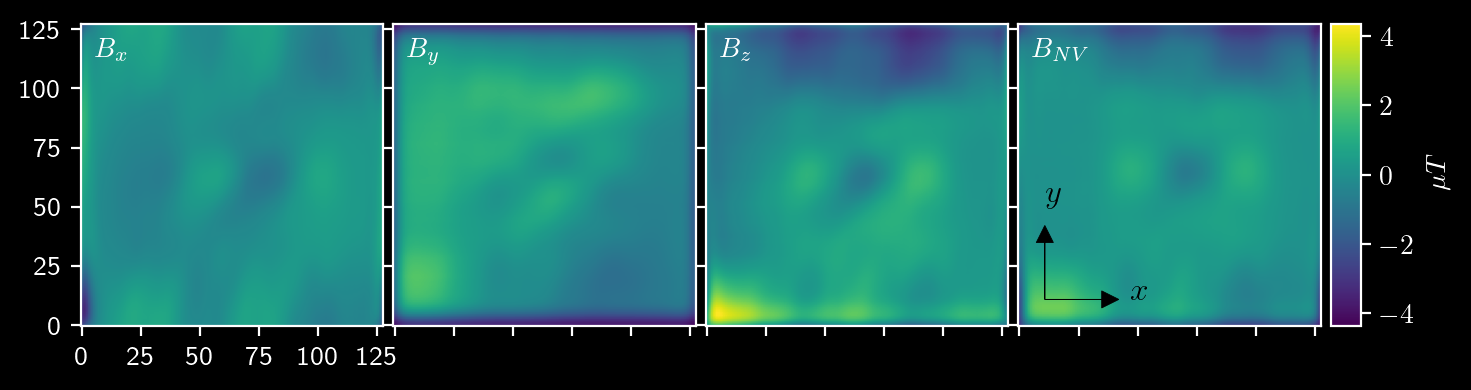

tensor([[[[-0.1571, -0.1602, -0.1628,  ...,  0.2738,  0.2775,  0.2815],
          [ 0.1005,  0.0818,  0.0662,  ...,  0.1398,  0.1397,  0.1411],
          [ 0.2257,  0.1963,  0.1719,  ...,  0.0776,  0.0762,  0.0773],
          ...,
          [ 0.1927,  0.1843,  0.1747,  ...,  0.0232,  0.0049, -0.0179],
          [ 0.1484,  0.1451,  0.1403,  ..., -0.0009, -0.0252, -0.0545],
          [-0.0655, -0.0582, -0.0532,  ...,  0.1073,  0.0845,  0.0571]]]],
       grad_fn=<SliceBackward0>)

In [17]:
recon.propagate(B, epochs=0)

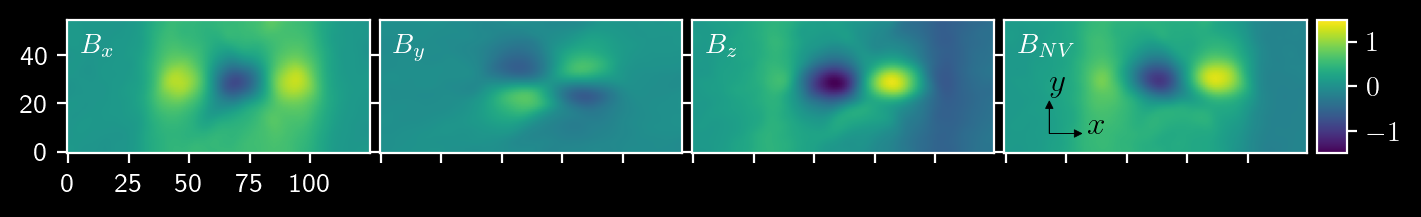

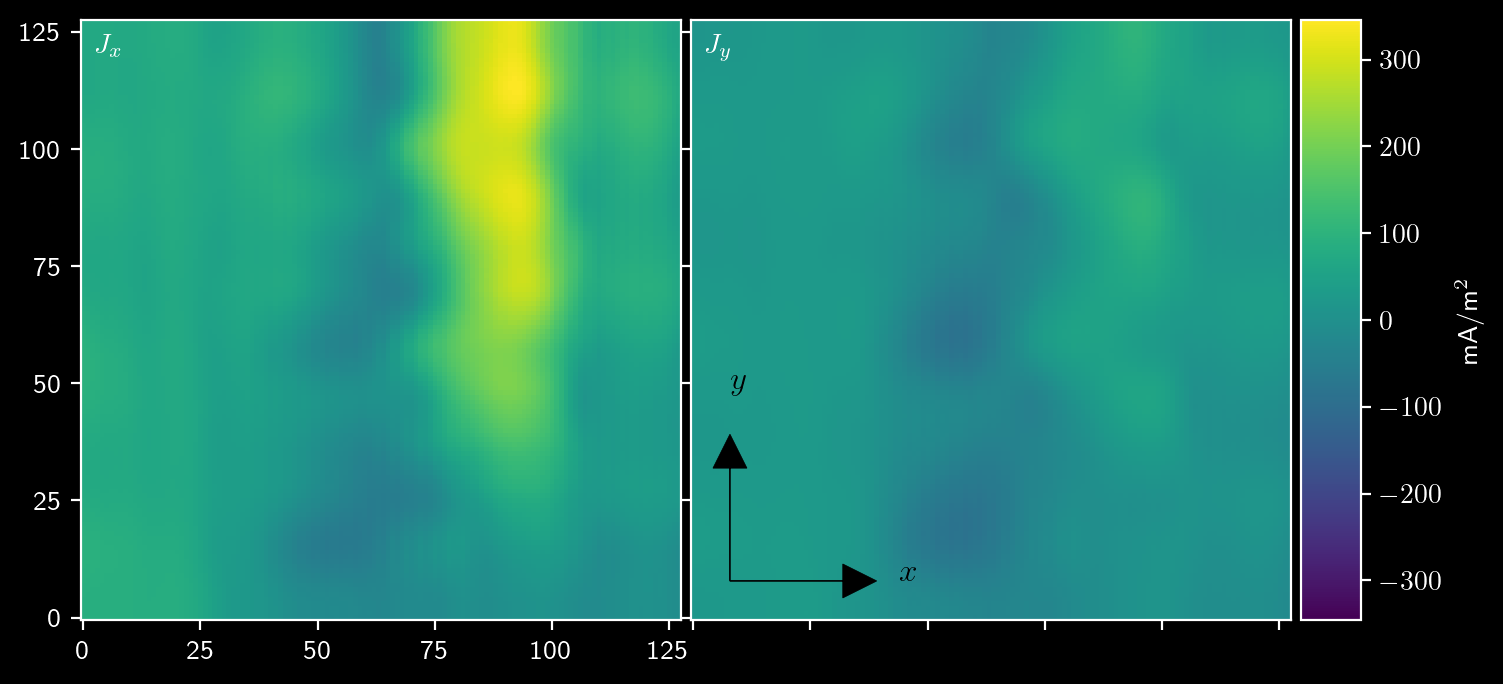

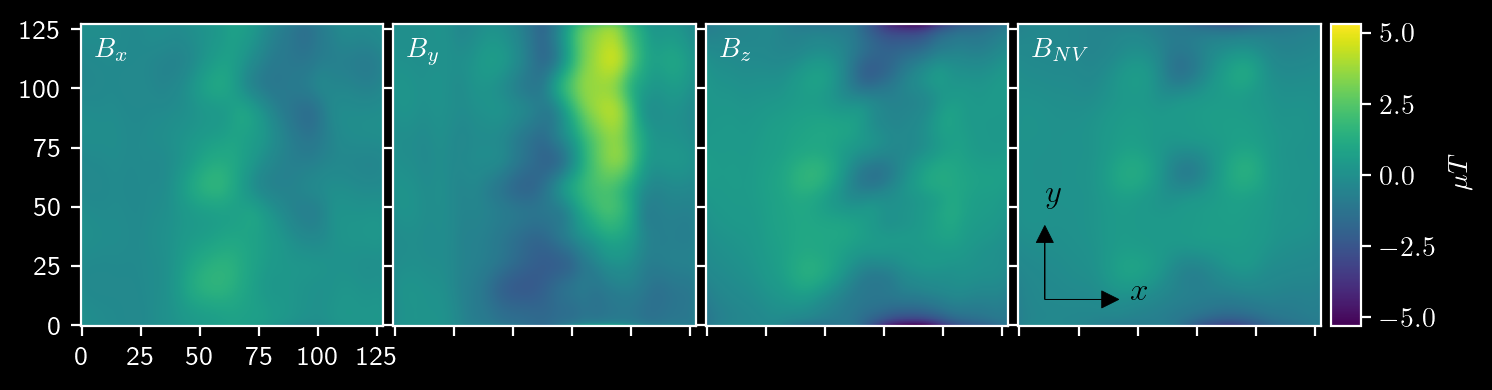

tensor([[[[-0.0770, -0.0545, -0.0329,  ...,  0.1250,  0.1191,  0.1117],
          [-0.0596, -0.0375, -0.0161,  ...,  0.1294,  0.1231,  0.1151],
          [-0.0482, -0.0265, -0.0056,  ...,  0.1292,  0.1225,  0.1141],
          ...,
          [-0.0569, -0.0334, -0.0132,  ...,  0.0918,  0.0867,  0.0815],
          [-0.0814, -0.0589, -0.0396,  ...,  0.0728,  0.0675,  0.0624],
          [-0.1111, -0.0896, -0.0708,  ...,  0.0567,  0.0511,  0.0459]]]],
       grad_fn=<SliceBackward0>)

In [ ]:
model.transform(recon.net(pipe.transform(B)))

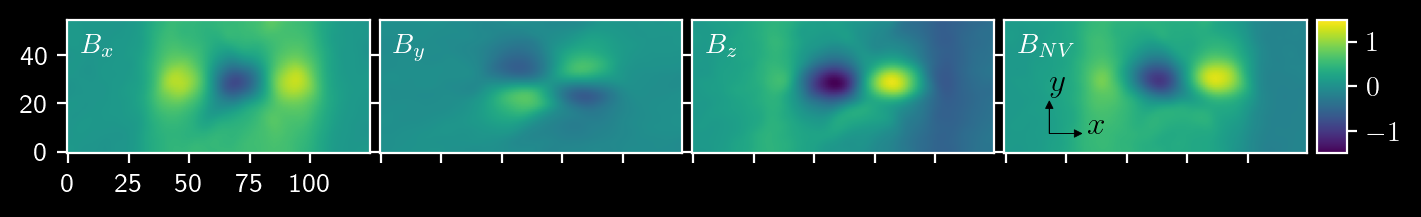

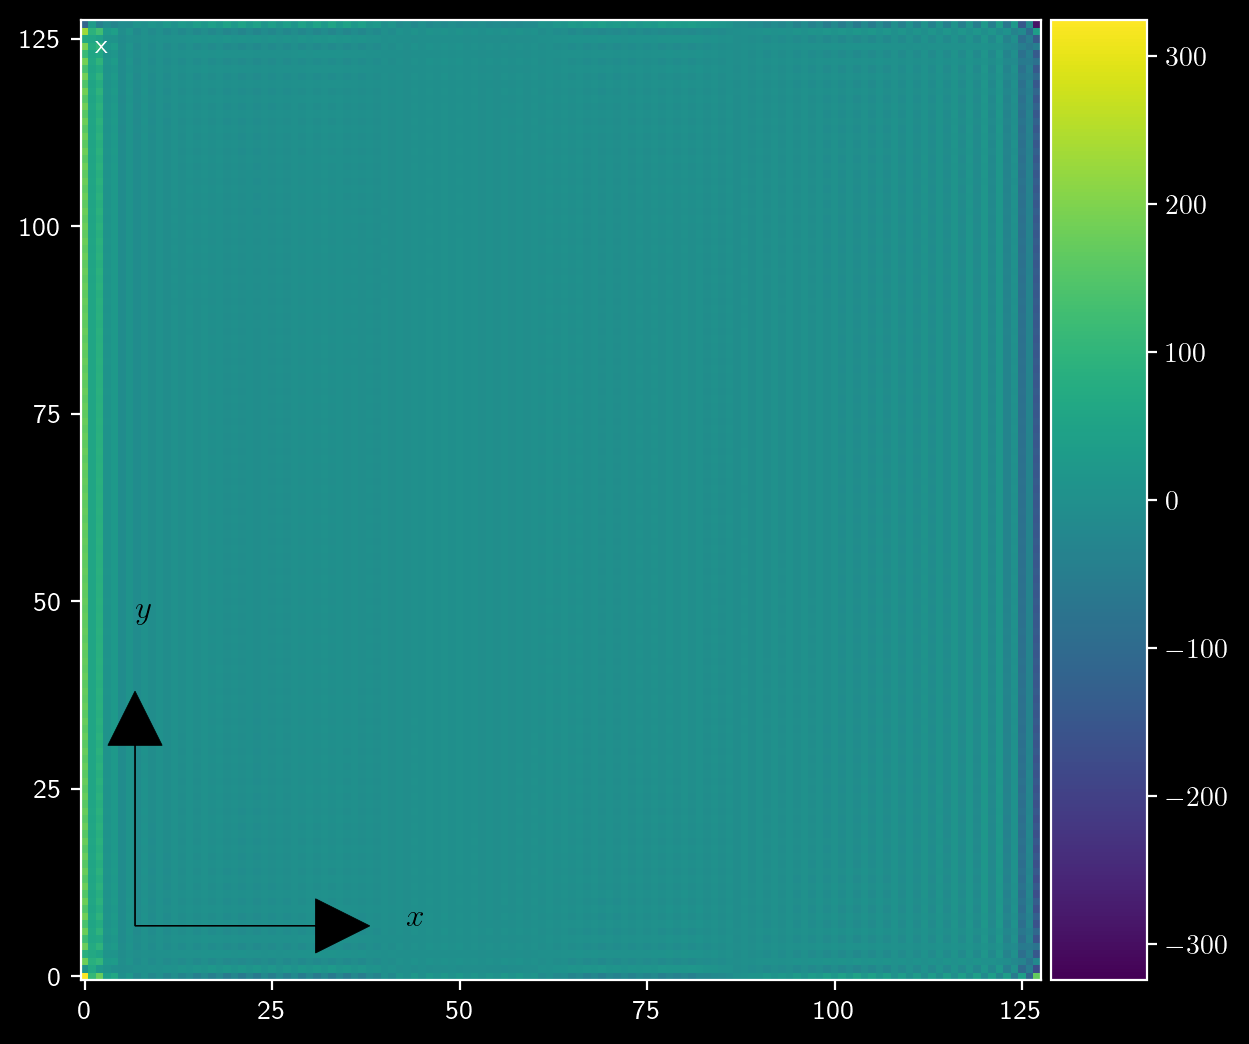

tensor([[[ 324.4017,   11.6621,  180.2606,  ...,   69.4824,  229.3135,
          -113.9964],
         [ 108.9273,   68.0290,   86.0100,  ...,   59.9167,   91.7029,
            31.2048],
         [ 172.6119,   25.7779,  103.1231,  ...,   47.2763,  125.8597,
           -39.6163],
         ...,
         [  41.6991, -101.1485,  -35.1177,  ...,  -86.4362,  -16.4518,
          -145.2549],
         [-113.4257,  -46.8222,  -74.9095,  ...,  -48.0925,  -94.5747,
           -10.6762],
         [ 171.3978, -171.3576,  -15.9875,  ..., -141.5284,   38.1462,
          -289.2709]]], grad_fn=<SelectBackward0>)

In [16]:
PlotResults()(FourierDivergence2d()(model["JxJy"](recon.net(pipe.transform(B)))))

In [ ]:
recon_lrelu = Prototype(
    net=GioUNet(size_out=(128, 128), n_channels_in=1, n_channels_out=2),
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    )

  epoch    div_loss    field_loss    train_loss       dur
-------  ----------  ------------  ------------  --------
    201    2.14e-03      2.03e-01      2.05e-01  1.13e-01
    220    2.03e-03      2.03e-01      2.05e-01  5.44e-02
    240    1.94e-03      2.03e-01      2.05e-01  4.75e-02
    260    1.87e-03      2.03e-01      2.05e-01  1.83e-01
    280    1.80e-03      2.03e-01      2.05e-01  2.43e-01
    300    1.74e-03      2.03e-01      2.05e-01  1.11e-01
    320    1.69e-03      2.03e-01      2.05e-01  1.25e-01
    340    1.64e-03      2.03e-01      2.05e-01  1.45e-01
    360    1.59e-03      2.03e-01      2.05e-01  3.20e-02
    380    1.55e-03      2.03e-01      2.05e-01  3.72e-02
    400    1.51e-03      2.03e-01      2.05e-01  3.88e-02


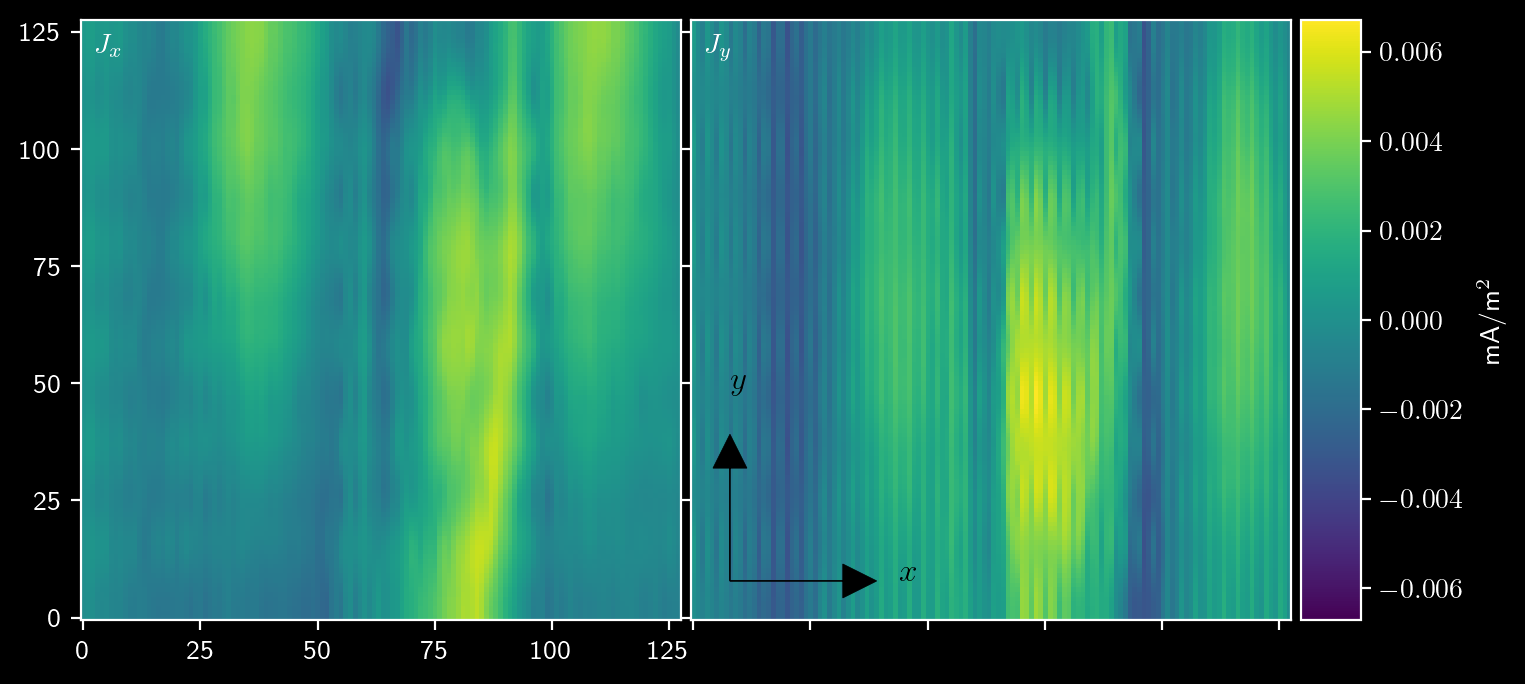

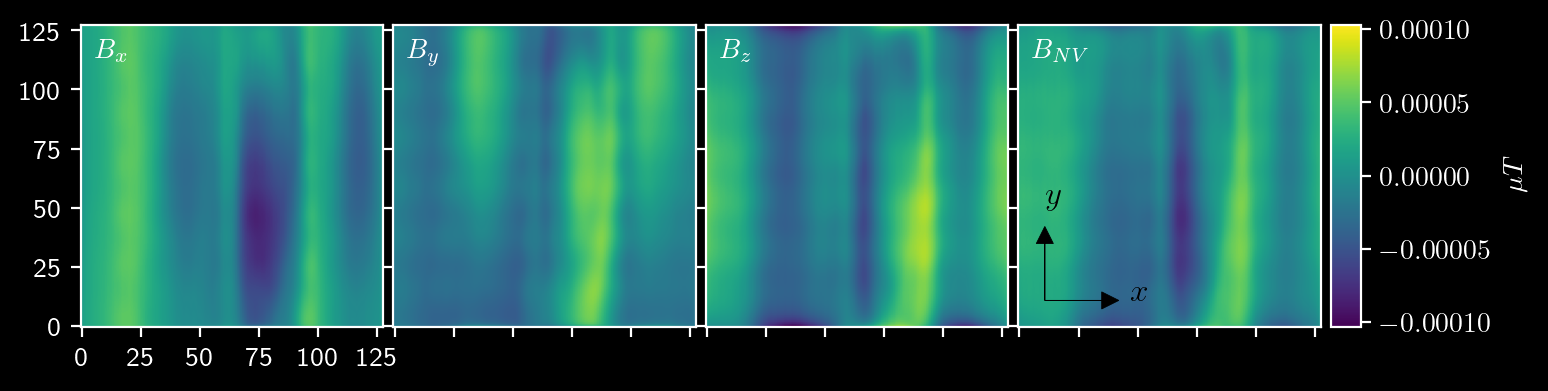

tensor([[[[3.3120e-05, 3.3062e-05, 3.2881e-05,  ..., 2.6814e-05,
           2.6655e-05, 2.6609e-05],
          [3.2203e-05, 3.2098e-05, 3.1893e-05,  ..., 2.6024e-05,
           2.5930e-05, 2.5937e-05],
          [3.2432e-05, 3.2312e-05, 3.2077e-05,  ..., 2.5962e-05,
           2.5888e-05, 2.5937e-05],
          ...,
          [1.4536e-05, 1.4525e-05, 1.4368e-05,  ..., 1.5841e-05,
           1.5868e-05, 1.6050e-05],
          [1.7753e-05, 1.7795e-05, 1.7707e-05,  ..., 1.8883e-05,
           1.8864e-05, 1.8970e-05],
          [2.1766e-05, 2.1827e-05, 2.1818e-05,  ..., 2.2630e-05,
           2.2629e-05, 2.2692e-05]]]], grad_fn=<SliceBackward0>)

In [ ]:
recon_lrelu.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.001)

## Learning on scalar parameters

In [ ]:
# Model with loss that includes divergence in J field

from abc import ABC, abstractmethod


_, W, H = B.shape

expanded_size = (128, 128)

mask = torch.zeros((2,) + expanded_size)
mask[0, 25:120, 40:100] = 1.0
mask[1, 25:120, :] = 1.0
mask = GaussianFilter(2.0)(mask)
PlotResults()(mask)

pipe = Pipe(
    [
        ("add_batch_dim", Function(lambda x: x[None, ...])),
        ("gaussian_filter", GaussianFilter(2.0)),
        ("plot1", PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"])),
        ("B_NV", Function(lambda x: x[..., 0:1, :, :])),
    ]
)

pipe.fit(B).transform(B)

model = Pipe(
    [
        # (
        #     "JxJy",
        #     Union(
        #         [("Jx", "passthrough"), ("Jy", FourierZeroDivergenceConstraint2d())],
        #         dim=-3,
        #     ),
        # ),
        ("plot1", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
        ("mask", Function(lambda x: x * mask)),
        ("plot1", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
        (
            "B",
            CurrentLayerToField(
                dx=dx, dy=dy, height=height, layer_thickness=layer_thickness
            ),
        ),
        (
            "B+B_NV",
            Union(
                [("B", "passthrough"), ("B_NV", Projection(theta=theta, phi=phi))],
                dim=-3,
            ),
        ),
        (
            "plot2",
            PlotResults(
                labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$"
            ),
        ),
        ("B_NV", Function(lambda x: x[..., [-1], :, :])),
        ("ROI", Function(T.CenterCrop(size=(W, H)))),
    ]
)


class Method(ABC):
    
    @abstractmethod
    def loss_fn(model, net_output):
        pass
    
    
class HarvardData1203(Method):
    def loss_fn(model, net_output):
        J, theta, phi = net_output
        field_loss, div_loss = model.propagate(
            JxJy=J, proj__theta=theta, proj__phi=phi
        ).get_loss("B", "div")

        return field_loss + div_loss


recon = Prototype(
    net=GioUNet(
        size_out=expanded_size,
        n_channels_in=1,
        n_channels_out=2,
        enc_chs=(64, 128, 256),
        dec_chs=(256, 128, 64),
    ),
    model=model,
    pipe=pipe,
    max_epochs=20,
    optimizer=torch.optim.SGD,
)

In [ ]:
recon = Prototype(
    net=GioUNet(
        size_out=expanded_size,
        n_channels_in=1,
        n_channels_out=2,
        enc_chs=(64, 128, 256),
        dec_chs=(256, 128, 64),
    ),
    model=model,
    pipe=pipe,
    max_epochs=20,
    optimizer=torch.optim.SGD,
)

## Masks


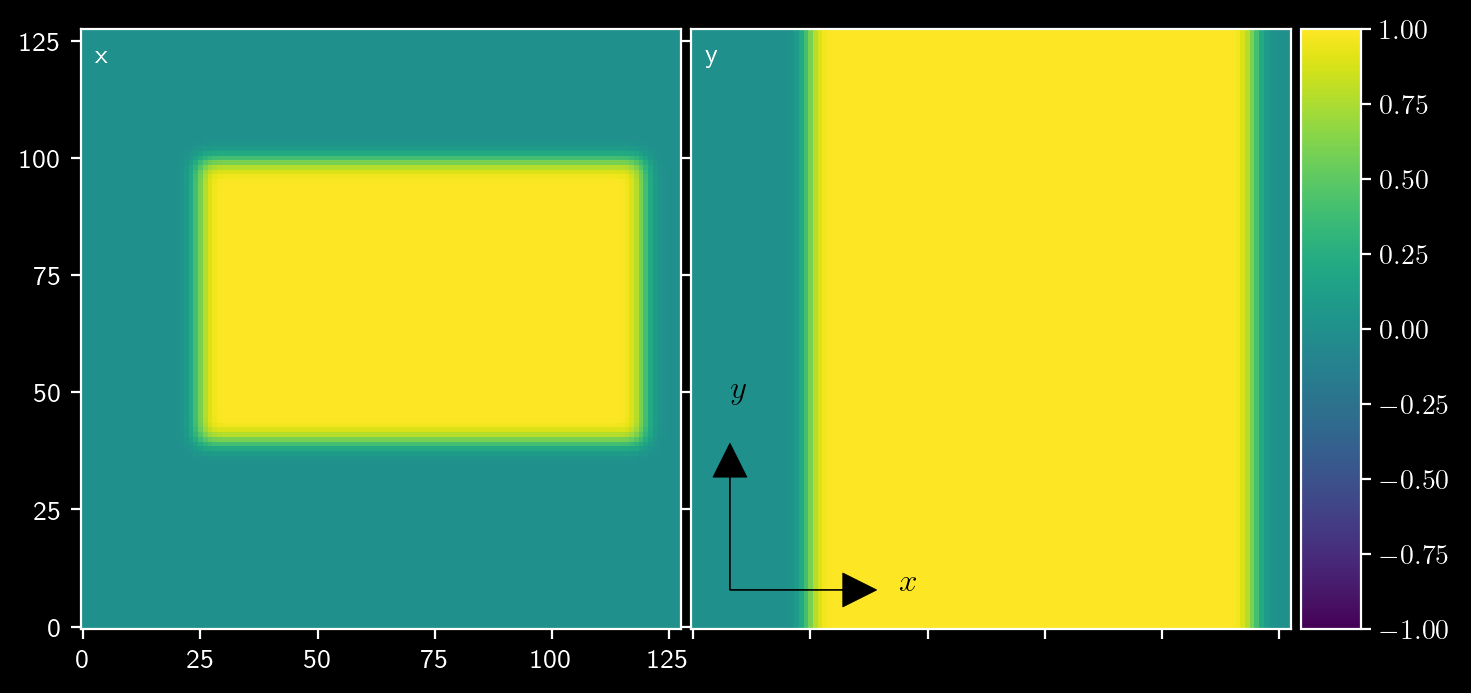

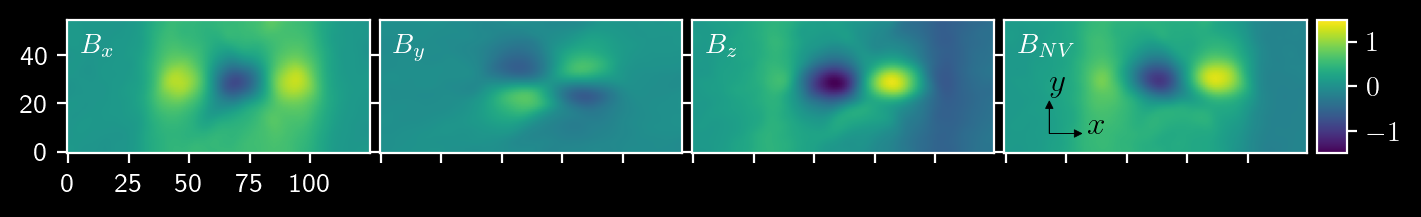

In [46]:
_, W, H = B.shape

expanded_size = (128, 128)

mask = torch.zeros((2,) + expanded_size)
mask[0, 25:120, 40:100] = 1.0
mask[1, 25:120, :] = 1.0
mask = GaussianFilter(2.0)(mask)
PlotResults()(mask)

pipe = Pipe(
    [
        ("add_batch_dim", Function(lambda x: x[None, ...])),
        ("gaussian_filter", GaussianFilter(2.0)),
        ("plot1", PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"])),
        ("B_NV", Function(lambda x: x[..., 0:1, :, :])),
    ]
)

pipe.fit(B).transform(B)

model = Pipe(
    [
        # (
        #     "JxJy",
        #     Union(
        #         [("Jx", "passthrough"), ("Jy", FourierZeroDivergenceConstraint2d())],
        #         dim=-3,
        #     ),
        # ),
        ("plot1", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
        ("mask", Function(lambda x: x * mask)),
        ("plot1", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
        (
            "B",
            CurrentLayerToField(
                dx=dx, dy=dy, height=height, layer_thickness=layer_thickness
            ),
        ),
        (
            "B+B_NV",
            Union(
                [("B", "passthrough"), ("B_NV", Projection(theta=theta, phi=phi))],
                dim=-3,
            ),
        ),
        (
            "plot2",
            PlotResults(
                labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$"
            ),
        ),
        ("B_NV", Function(lambda x: x[..., [-1], :, :])),
        ("ROI", Function(T.CenterCrop(size=(W, H)))),
    ]
)

recon = Prototype(
    net=GioUNet(
        size_out=expanded_size,
        n_channels_in=1,
        n_channels_out=2,
        enc_chs=(64, 128, 256),
        dec_chs=(256, 128, 64),
    ),
    model=model,
    pipe=pipe,
    max_epochs=20,
    optimizer=torch.optim.SGD,
)

  epoch    train_loss       dur
-------  ------------  --------
    960      1.23e-02  2.39e-01
   1000      1.33e-02  1.11e-01
   1100      7.78e-03  1.79e-01
   1200      5.74e-03  9.36e-02
   1300      5.33e-03  9.49e-02
   1400      3.85e-03  7.31e-02
   1500      4.29e-03  8.10e-02
   1600      2.73e-03  1.05e-01
   1700      2.44e-03  3.92e-01
   1800      2.31e-03  1.21e-01
   1900      1.67e-03  8.67e-02
   2000      1.31e-03  7.41e-02
   2100      1.58e-03  8.92e-02
   2200      1.40e-03  8.27e-02
   2300      9.67e-04  8.08e-02
   2400      9.75e-04  1.00e-01
   2500      1.12e-03  1.08e-01
   2600      9.80e-04  1.61e-01
   2700      9.23e-04  1.43e-01
   2800      1.12e-03  8.22e-02


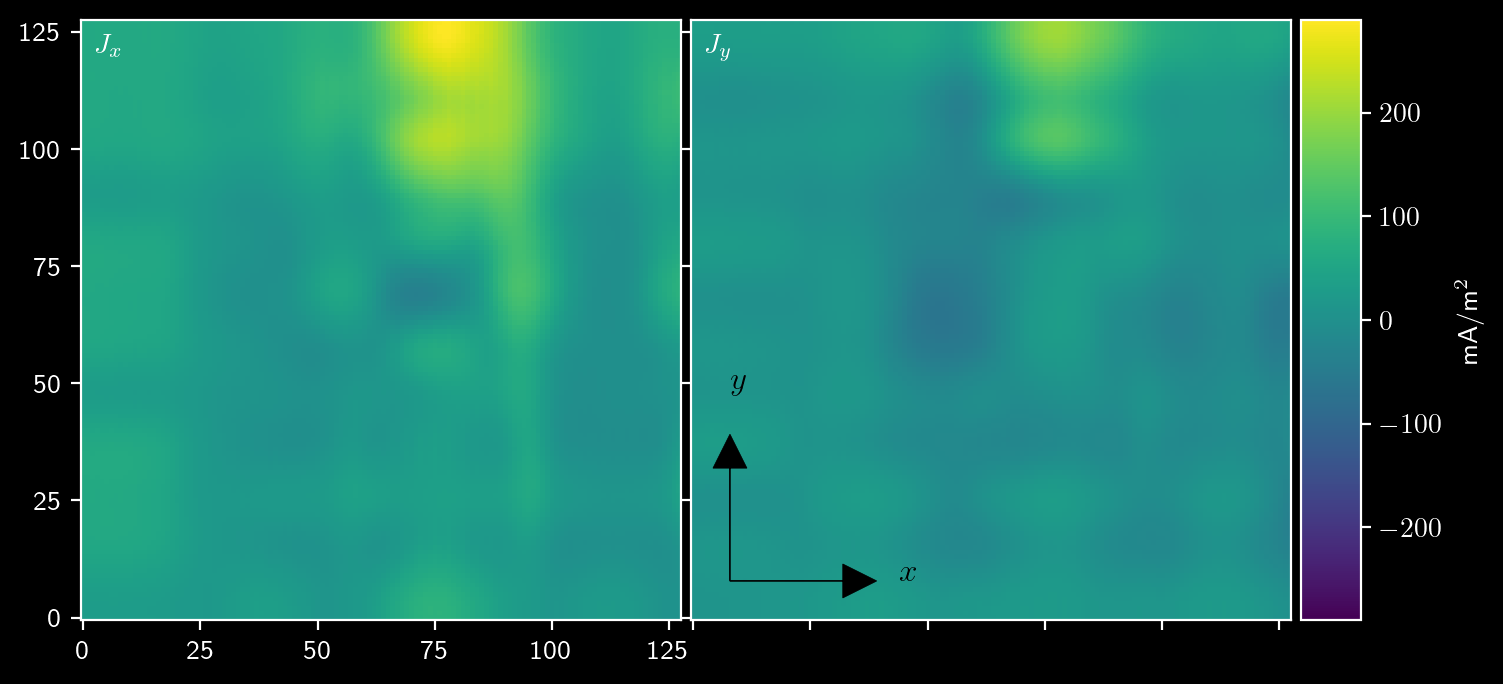

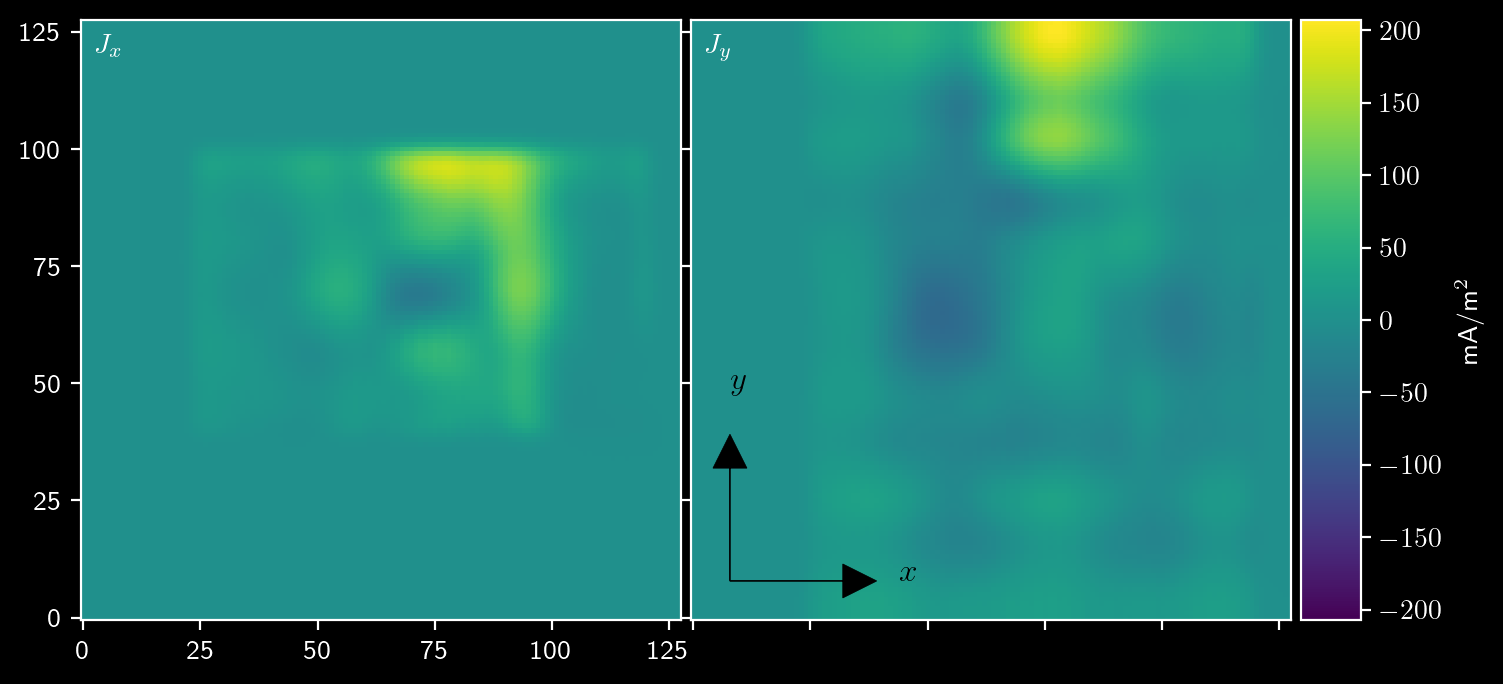

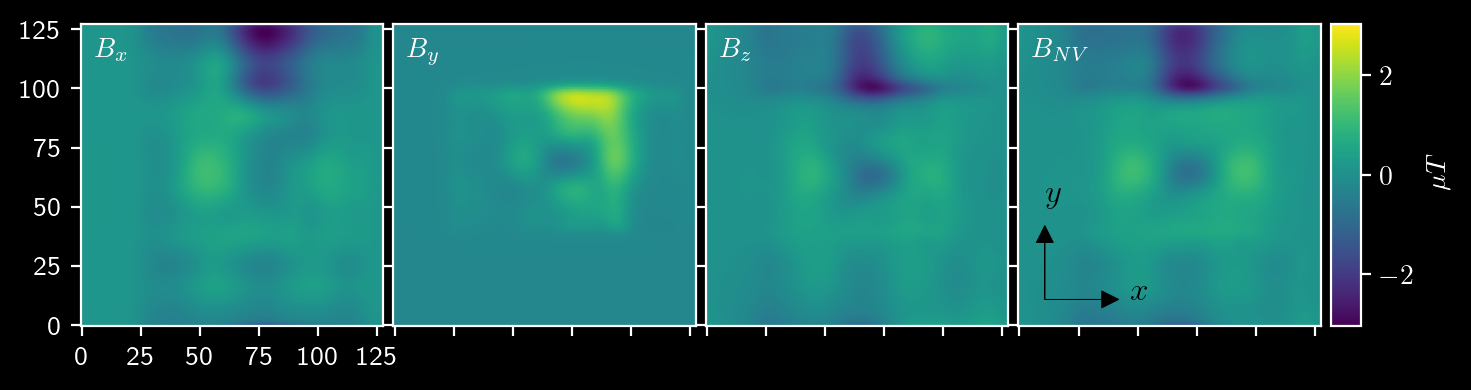

tensor([[[[0.0683, 0.0690, 0.0700,  ..., 0.0562, 0.0521, 0.0478],
          [0.0682, 0.0694, 0.0707,  ..., 0.0525, 0.0481, 0.0434],
          [0.0679, 0.0695, 0.0711,  ..., 0.0491, 0.0444, 0.0393],
          ...,
          [0.0636, 0.0607, 0.0590,  ..., 0.0904, 0.0898, 0.0891],
          [0.0645, 0.0624, 0.0613,  ..., 0.0819, 0.0803, 0.0787],
          [0.0657, 0.0644, 0.0638,  ..., 0.0752, 0.0729, 0.0705]]]],
       grad_fn=<SliceBackward0>)

In [48]:
recon.propagate(B, epochs=2000, print_log_every=100, callbacks__print_log__floatfmt=".2e", lr=1)

## Reconstruct components independently

Below we code an architecture that reconstructs the two components of J independently. It is a simple convolutional network that takes as input one component of B and outputs a single component of J. There are two such networks the result of which are added concatenated to produce the final result.

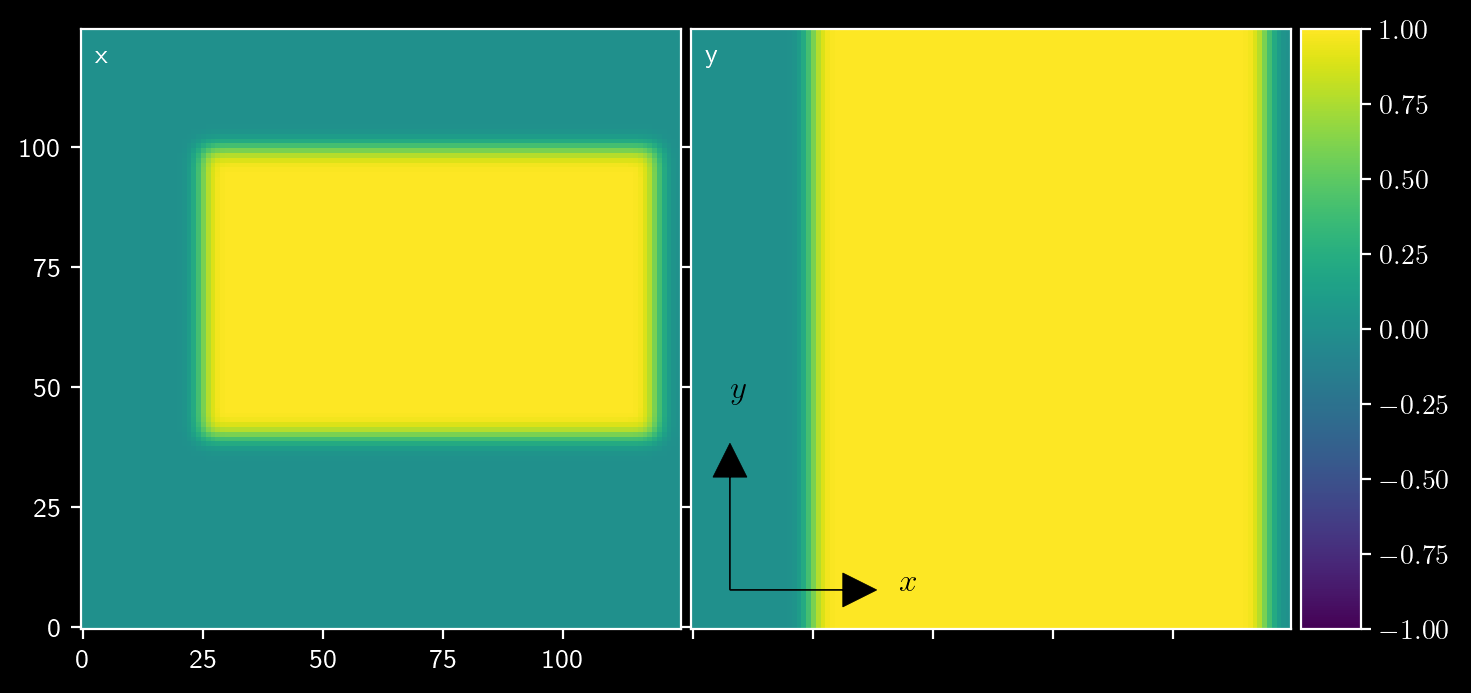

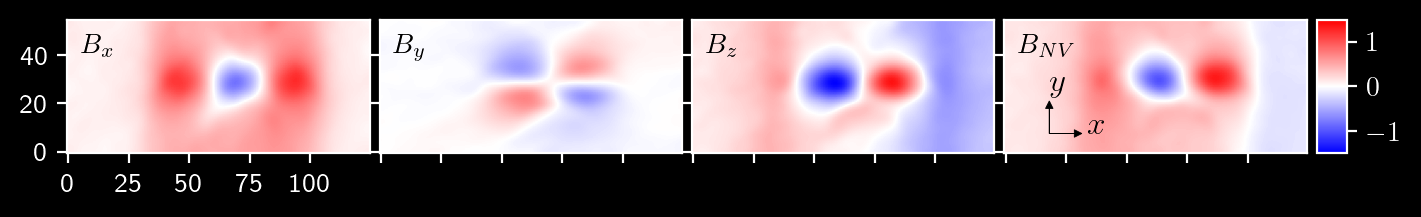

In [63]:
_, W, H = B.shape

theta = 35.0  # predicted by David
phi = -55.0              # degrees

expanded_size = (125, 125)

mask = torch.zeros((2,) + expanded_size)
mask[0, 25:120, 40:100] = 1.0
mask[1, 25:120, :] = 1.0
mask = GaussianFilter(2.0)(mask)
PlotResults()(mask)

offset = torch.zeros((2,) + expanded_size)
offset[1, 25:100, 100:] = 2.
offset[1, 25:100, :25] = 2.

pipe = Pipe(
    [
        ("add_batch_dim", Function(lambda x: x[None, ...])),
        ("gaussian_filter", GaussianFilter(2.0)),
        ("plot1", PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr")),
        ("B_NV", Function(lambda x: x[..., 0:1, :, :])),
    ]
)

pipe.fit(B).transform(B)

model = Pipe(
    [
        ("plot", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$", cmap="PuOr")),
        ("mask", Function(lambda x: x + offset)),
        ("plot", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$", cmap="PuOr")),
        (
            "B",
            CurrentLayerToField(
                dx=dx, dy=dy, height=height, layer_thickness=layer_thickness
            ),
        ),
        (
            "B+B_NV",
            Union(
                [("B", "passthrough"), ("B_NV", Projection(theta=theta, phi=phi))],
                dim=-3,
            ),
        ),
        (
            "plot2",
            PlotResults(
                labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$",
                cmap="bwr"
            ),
        ),
        ("B_NV", Function(lambda x: x[..., [-1], :, :])),
        ("ROI", Function(T.CenterCrop(size=(W, H)))),
    ]
)

class Net2C(torch.nn.Module):
    
    def __init__(self, size_out, n_channels_in, n_channels_out, enc_chs=(64, 128, 256), dec_chs=(256, 128, 64)):
        super().__init__()
        self.n_channels_in = n_channels_in
        self.n_channels_out = n_channels_out
        self.comp1 = GioUNet(n_channels_in, n_channels_out, enc_chs, dec_chs, size_out)
        self.comp2 = GioUNet(n_channels_in, n_channels_out, enc_chs, dec_chs, size_out)
        
    def forward(self, x):
        c1 = self.comp1(x)
        c2 = self.comp2(x)
        return torch.cat([c1, c2], dim=1)
        

recon = Prototype(
    net=Net2C(size_out=expanded_size, n_channels_in=1, n_channels_out=1),
    model=model,
    pipe=pipe,
    max_epochs=20,
    optimizer=torch.optim.SGD,
)

  epoch    train_loss       dur
-------  ------------  --------
    957      6.39e-02  5.01e-01
    960      6.20e-02  3.41e-01
    980      5.94e-02  2.73e-01
   1000      5.55e-02  3.77e-01
   1020      4.96e-02  4.89e-01
   1040      3.69e-02  2.90e-01
   1060      3.21e-02  2.18e-01
   1080      2.81e-02  2.26e-01
   1100      2.49e-02  1.45e-01
   1120      2.12e-02  2.35e-01
   1140      2.06e-02  2.41e-01


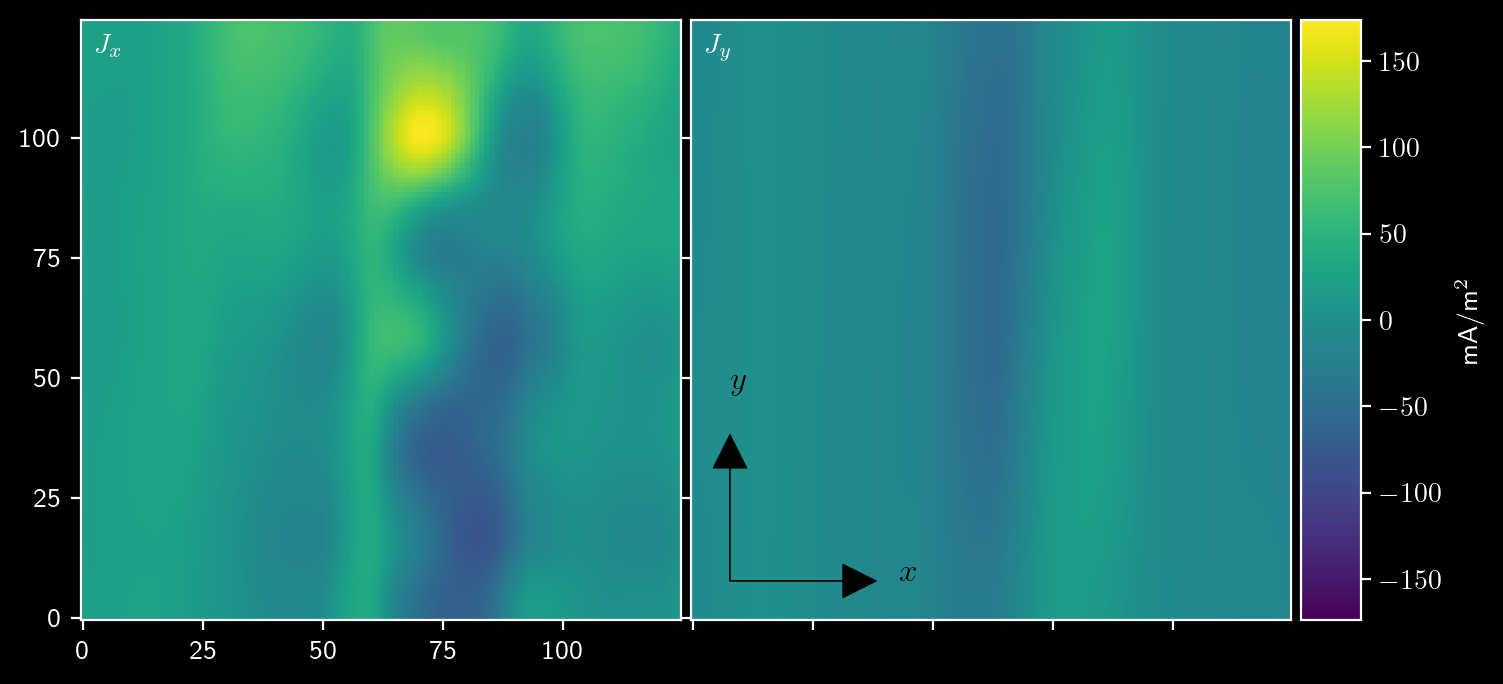

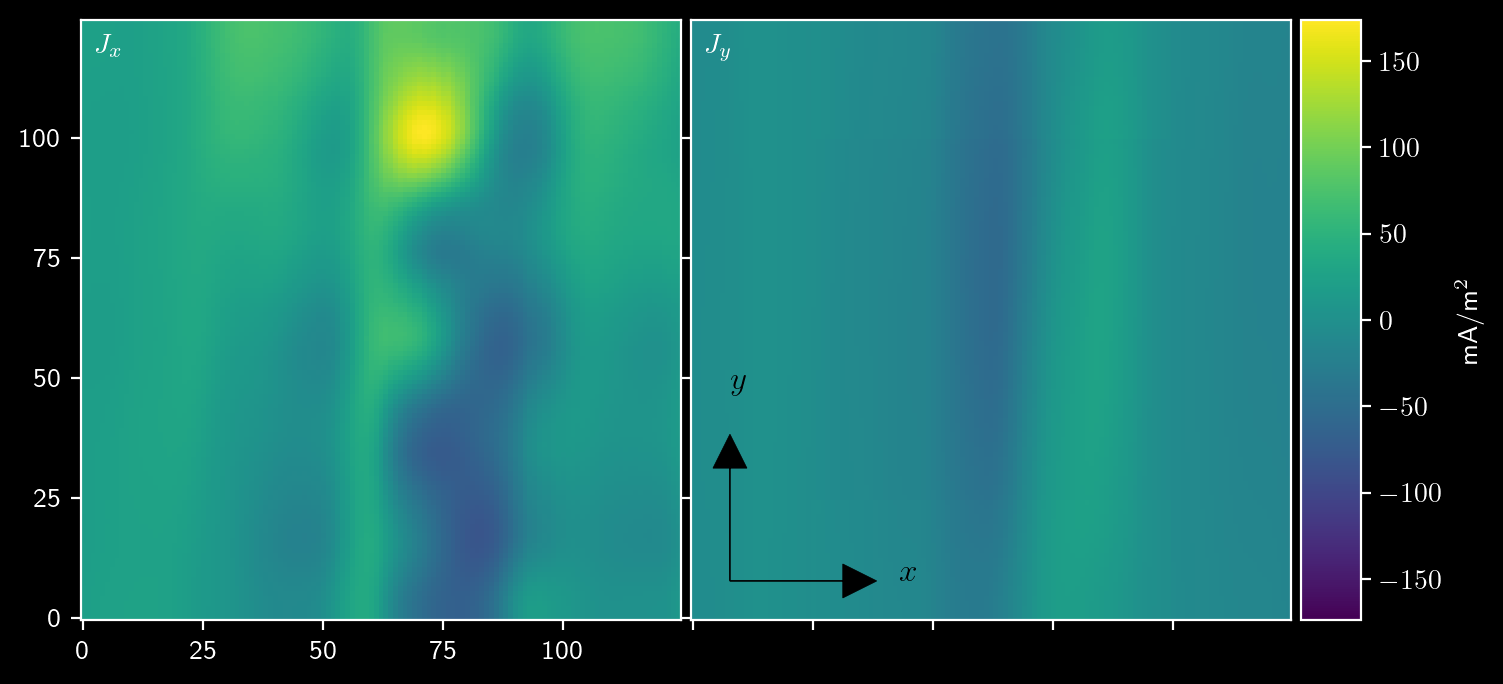

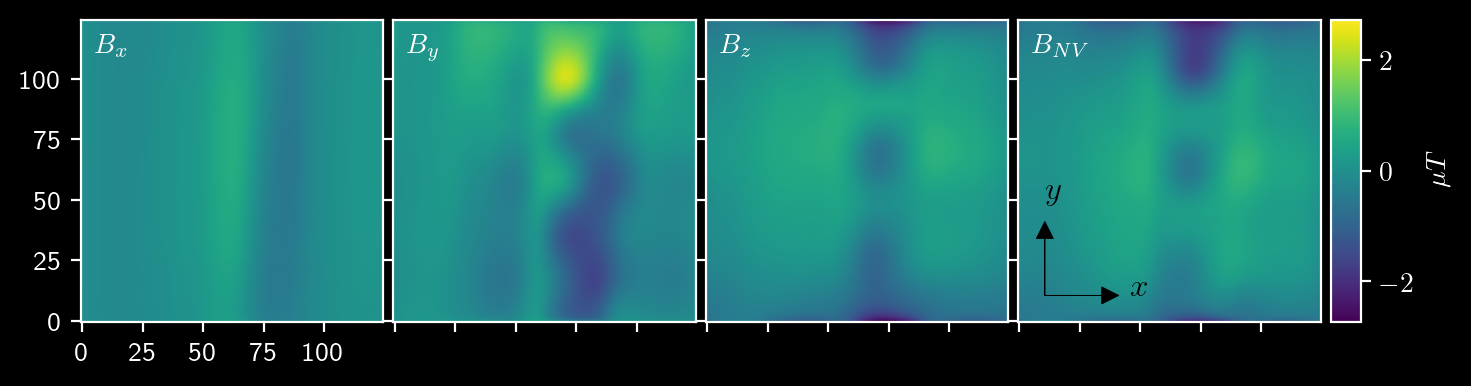

tensor([[[[-0.0812, -0.0796, -0.0781,  ..., -0.0548, -0.0625, -0.0698],
          [-0.0974, -0.0946, -0.0919,  ..., -0.0437, -0.0514, -0.0588],
          [-0.1020, -0.0982, -0.0946,  ..., -0.0321, -0.0398, -0.0473],
          ...,
          [ 0.0797,  0.0782,  0.0773,  ...,  0.0069, -0.0022, -0.0104],
          [ 0.0280,  0.0271,  0.0266,  ..., -0.0202, -0.0286, -0.0361],
          [-0.0333, -0.0333, -0.0329,  ..., -0.0471, -0.0549, -0.0621]]]],
       grad_fn=<SliceBackward0>)

In [60]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=1)

## Divergence loss

In [ ]:
_, W, H = B.shape

padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('add_batch_dim', Function(lambda x: x[None, ...])),
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"])),
    ('B_NV', Function(lambda x: x[..., 0:1, :, :])),
])

pipe.fit(B).transform(B);

model = Pipe([
    ('JxJy', Union([('Jx', 'passthrough'), ('Jy', FourierZeroDivergenceConstraint2d())], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
    ('ROI', Function(T.CenterCrop(size=(W, H)))),
])

recon = Prototype(
    net=GioCNN(size_out=(128, 128), n_channels_in=1, n_channels_out=1),
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    optimizer=torch.optim.SGD,)